# Act 1: Data-centric Workflows


In this notebook, you'll build a multimodal search pipeline using video as an example - a project that typically means managing separate systems: S3 for storage, a vector database to store vector embeddings (i.e., Pinecone, LanceDB), Postgres for metadata, plus an orchestration framework (i.e., Airflow, Prefect) to move data between them. With Pixeltable, you'll use a single system that handles storage, orchestration, and retrieval.

While we use video in our example here, Pixeltable works equally well with: 

- images
- audio files 
- documents like PDFs

The concepts you'll learn apply to all data types.

## In this notebook
1. **Storage** - Create a video table with schema for video, images, and text
2. **Orchestration** - Add computed columns that automatically calculate and persist video metadata
3. **Retrieval: Basic Queries** - Write SQL-like queries to select and filter data from tables
4. **Iterate: Create Views with Iterators** - Extract frames using iterators to create derived views
5. **Retrieval: Visual Search** - Build embedding indexes for image similarity search
6. **Retrieval: Cross-Modal Search** - Query with text to find similar images using CLIP embeddings
7. **Persistent Storage** - Demonstrate how data and computed columns persist across sessions

**Here's what you'll build:**

```
┌─────────────────────────────────────────────────────────────────────────────┐
│  INPUT            EMBED              SEARCH                   RESULTS       │
│                                                                             │
│  ┌────────┐      ┌────────┐        ┌──────────────┐         ┌────────────┐  │
│  │ Video  │─────▶│ CLIP   │───────▶│  Similarity  │────────▶│  Matching  │  │
│  │ Frames │      │Vectors │        │    Search    │         │   Frames   │  │
│  └────────┘      └────────┘        └──────────────┘         └────────────┘  │
│      │               │                     │                       │        │
│      │               │                     │                       │        │
│  Extract         Generate            Query with              Ranked by      │
│  frames          embeddings          reference               similarity     │
│  from video      using CLIP          image/text              score          │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

## 01 - Storage: Create a Video Table

First, we'll create a Pixeltable to store our video data. This provides persistent storage - your data and computed results are stored in the database. Learn more about [tables and data operations](https://docs.pixeltable.com/tutorials/tables-and-data-operations) and the [type system](https://docs.pixeltable.com/platform/type-system).

In [26]:
import pixeltable as pxt

In [ ]:
# Optional: Uncomment to start fresh by dropping the directory
pxt.drop_dir('primetime-workshop', force=True)

We'll start with a virtual directory to hold all our tables:

In [ ]:
pxt.create_dir('primetime-workshop')

In [4]:
t = pxt.create_table(
    'primetime-workshop/primetime_vids',
    schema={'video': pxt.Video,
            'title': pxt.String,
            'promo_img': pxt.Image,
            'promo_text': pxt.String},
    if_exists='replace_force'
)

Created table 'primetime_vids'.


The table is empty to start, but the schema is ready. We used [`create_table()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-create-table) to create a table with four columns, each of a different type. Learn more about [media types](https://docs.pixeltable.com/platform/type-system) supported by Pixeltable.


In [5]:
t

table 'primetime-workshop/primetime_vids'

 Column Name    Type Computed With
       video   Video              
       title  String              
   promo_img   Image              
  promo_text  String

We'll start with a single local video file and build up our video processing pipeline using this table. 

While we're using a local file here, Pixeltable can work with files from anywhere - local paths, URLs, or cloud storage. The key thing is that Pixeltable works with file references and only downloads files to disk on access. Read more about working with remote files: https://docs.pixeltable.com/howto/cookbooks/data/data-import-s3

In [6]:
t.insert([{
    'video': 'source/queens-gambit.mp4',
    'title': 'The Queens Gambit',
    'promo_img': 'source/queens-gambit-img.jpg',
    'promo_text': 'Set during the Cold War era, orphaned chess prodigy Beth Harmon struggles with addiction in a quest to become the greatest chess player in the world.'
}])

Inserted 1 row with 0 errors in 0.12 s (8.59 rows/s)


1 row inserted.

View the row we just inserted:

video,title,promo_img,promo_text
,The Queens Gambit,,"Set during the Cold War era, orphaned chess prodigy Beth Harmon struggles with addiction in a quest to become the greatest chess player in the world."

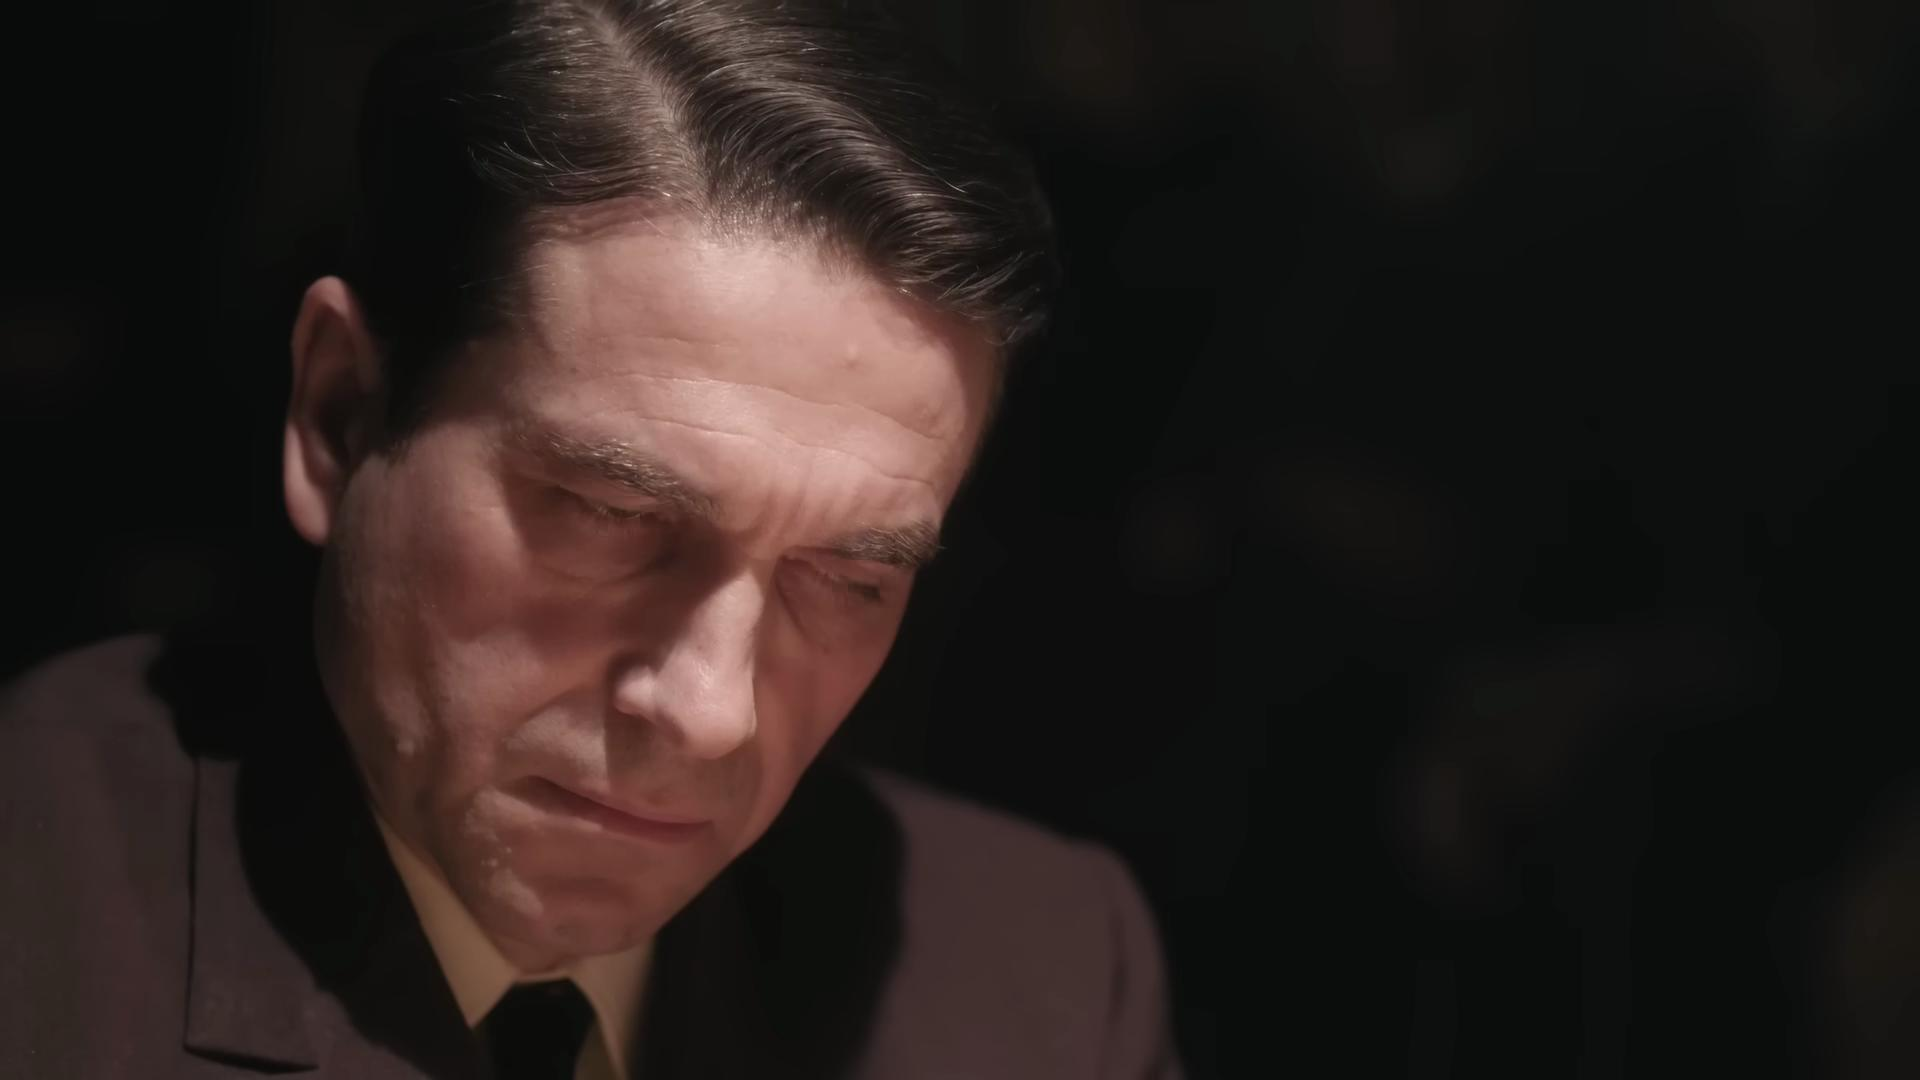
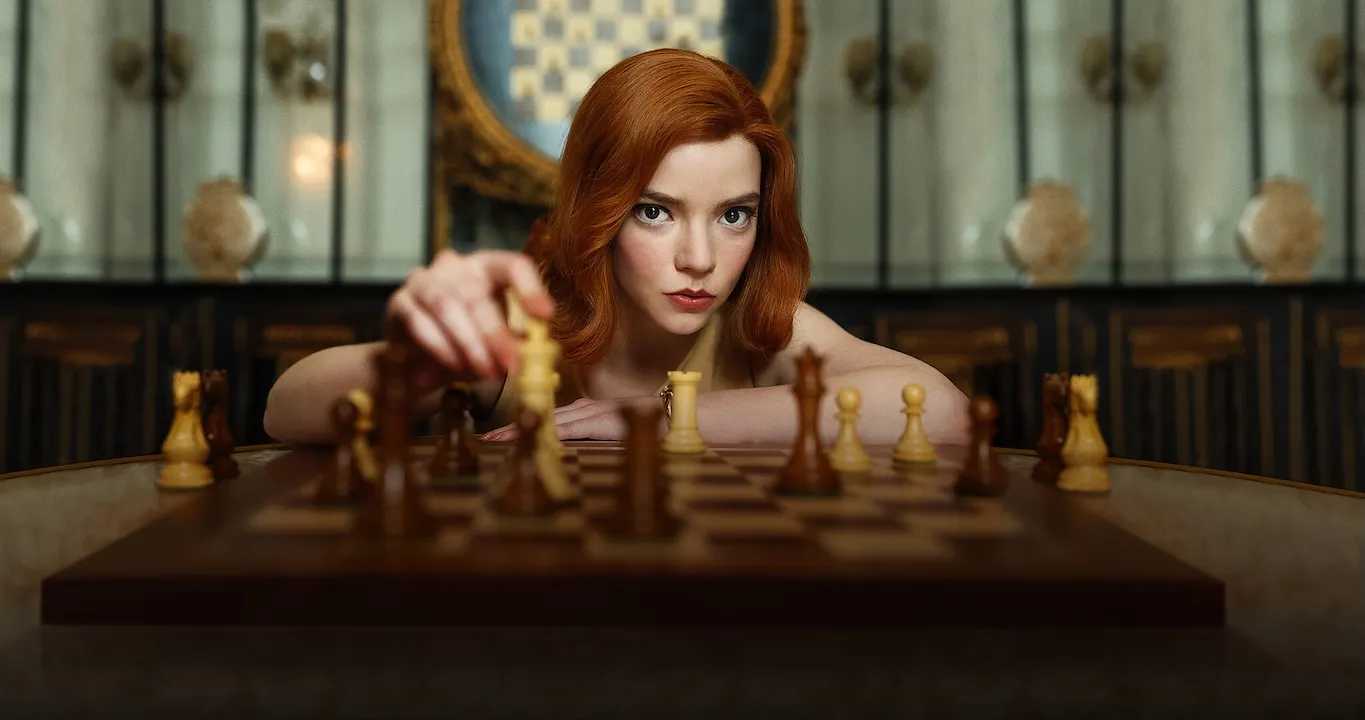

In [7]:
t.collect()

## 02 - Orchestration: Add Computed Columns

[Computed columns](https://docs.pixeltable.com/tutorials/computed-columns) are derived columns that can represent a wide range of application specific logic - data transformations, external API calls, local model inference, etc. These columns are stored persistently and automatically (re)computed when needed. 

![Computed Columns Diagram](workshop-extras/computed-columns.png)



Computed columns are defined with Pixeltable's expression language, which can be extended with:

- user-defined functions (UDFs), 
- aggregate functions (UDAs), and 
- iterators. 

Pixeltable contains a large number of built-in UDFs that range from data/media type specific logic (video, audio, etc.; example: `get_duration(tbl_name.video_col)` for videos as we'll use here) to external API calls for all of the popular inference providers.

You can find these under `pxt.functions` for each type of media: https://docs.pixeltable.com/sdk/latest/functions

In [8]:
import pixeltable.functions as pxtf

t.add_computed_column(duration=pxtf.video.get_duration(t.video))

Added 1 column value with 0 errors in 0.04 s (26.27 rows/s)


1 row updated.

Computed columns are a key concept in Pixeltable. Computed columns can build on other computed columns. You can create an arbitrarily complex DAG, and Pixeltable will automatically parallelize the execution based on the dependencies implicit in the DAG.

With every computed column, the data that is computed is persisted, and so is the metadata. We can view the updated table schema to confirm that Pixeltable has stored this new metadata for our new computed column:

In [9]:
t

table 'primetime-workshop/primetime_vids'

 Column Name    Type        Computed With
       video   Video                     
       title  String                     
   promo_img   Image                     
  promo_text  String                     
    duration   Float  get_duration(video)

video,duration
,377.043

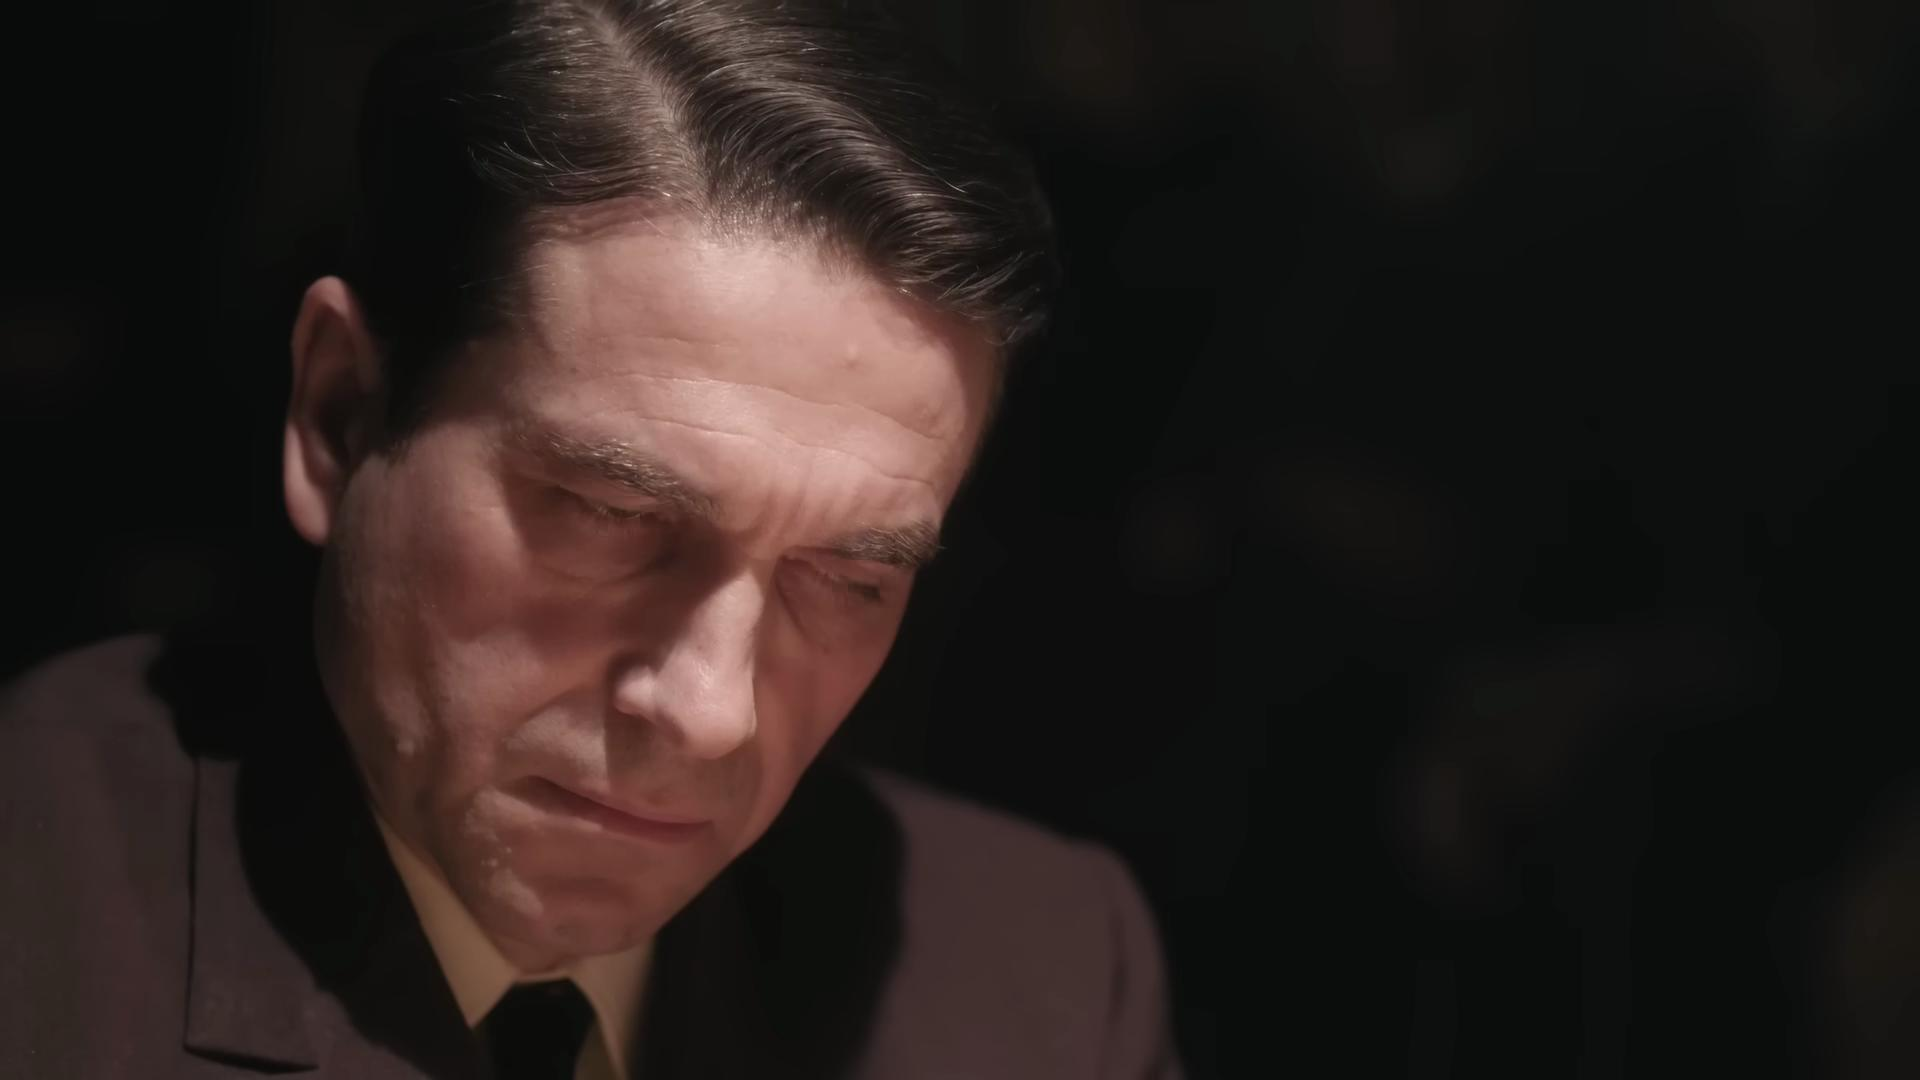

In [10]:
t.select(t.video, t.duration).collect()

The `duration` column is now a computed column. This means:

- **Everything is stored persistently** - The value and the metadata are in the database, not just in memory
- **It incrementally updates** - For any new rows inserted, Pixeltable will compute the duration automatically
- **It can be reused** - You can reference duration in other computed columns, and Pixeltable orchestrates the computation order


## 03 - Retrieval: Write Queries

You can also explore your data without storing results. [Queries](https://docs.pixeltable.com/tutorials/queries-and-expressions) let you experiment and iterate quickly. Here, we'll use the `extract_frame()` UDF for videos.

video,extract_frame
,

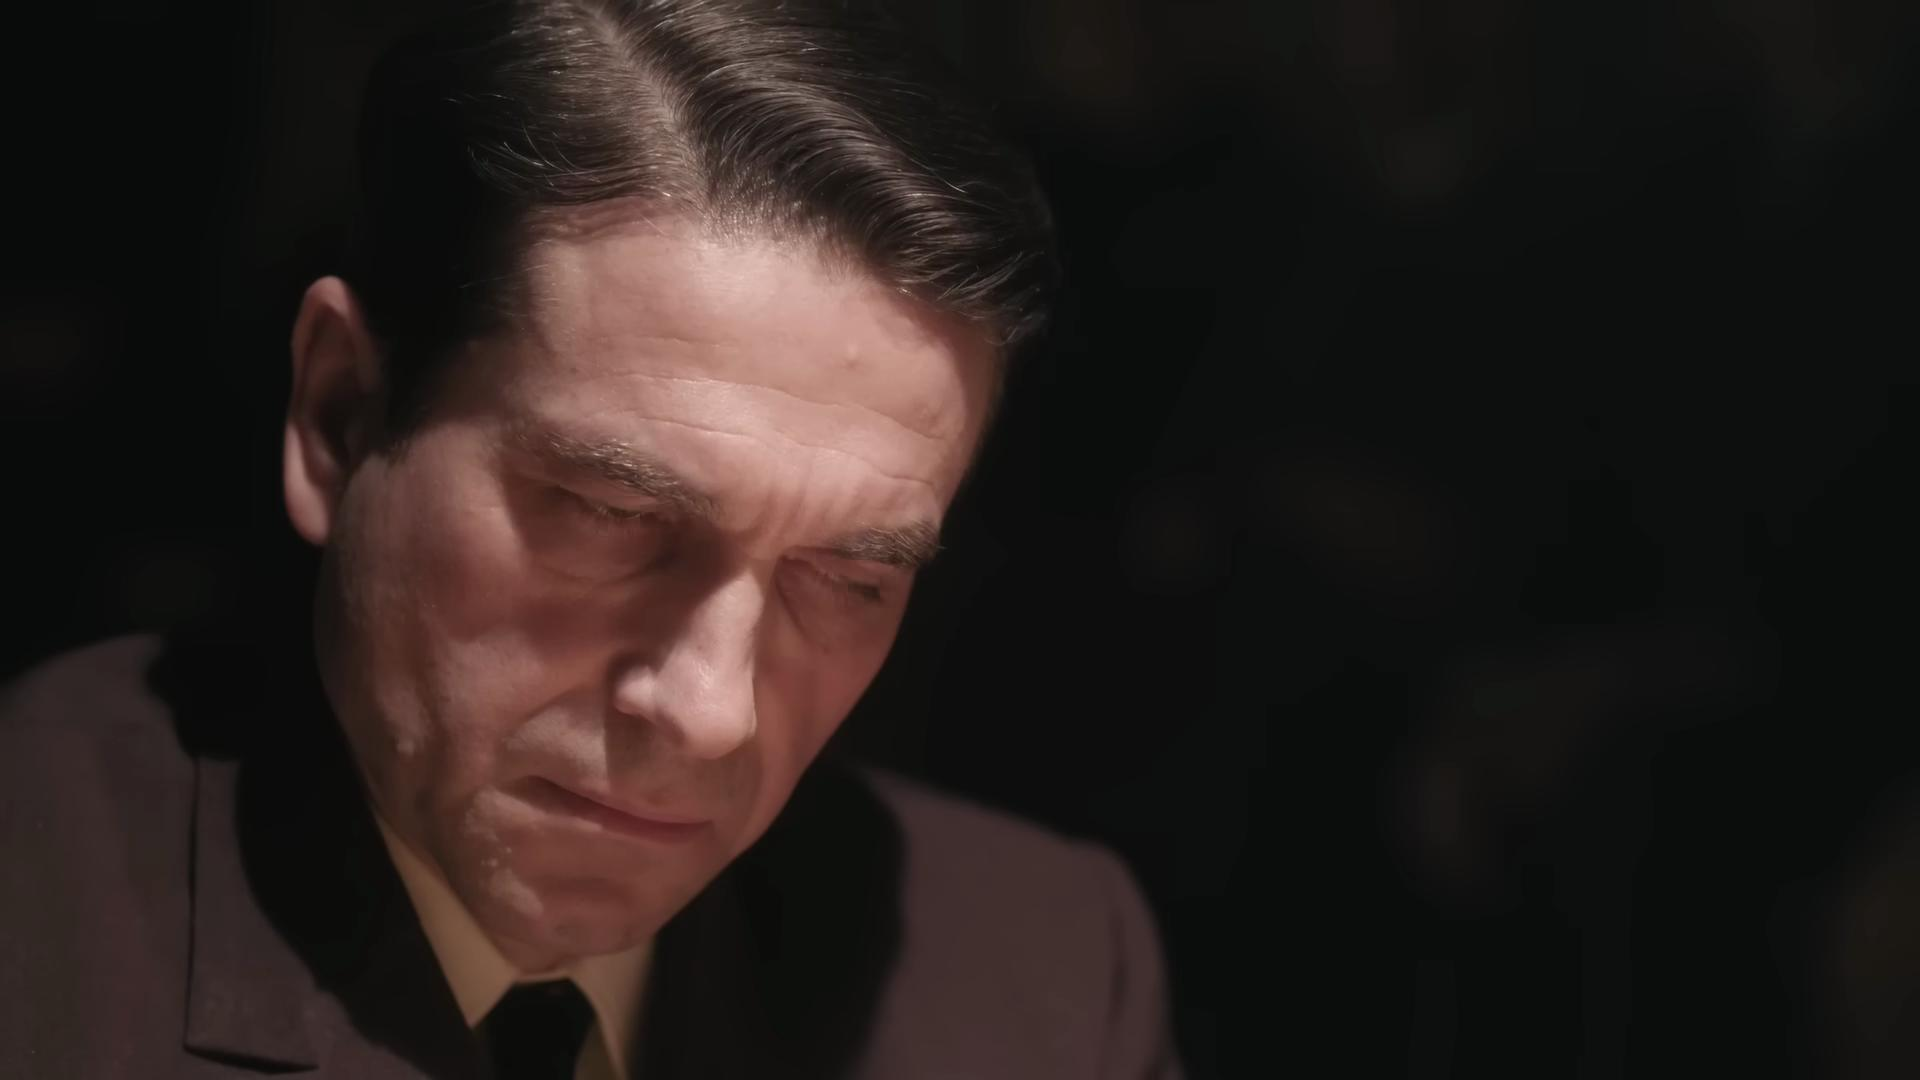
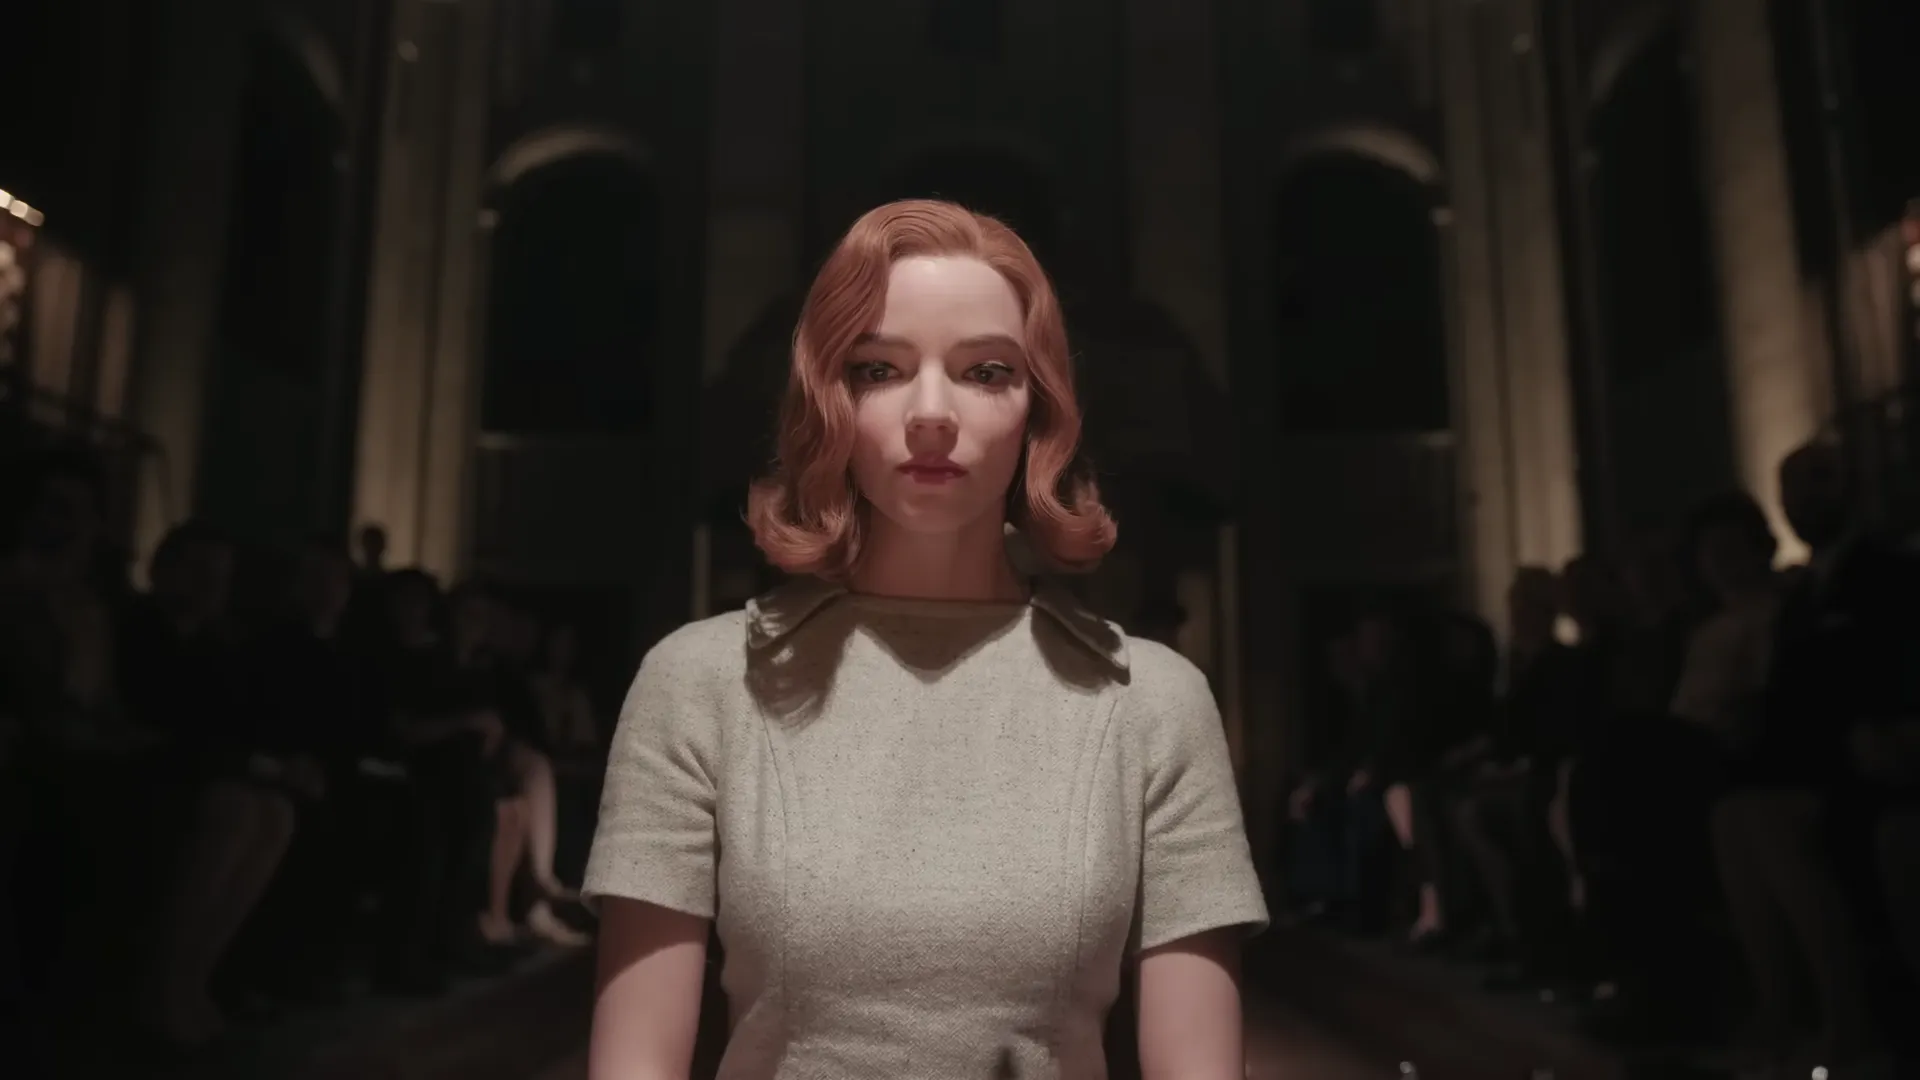

In [11]:
# Extract a frame at a specific timestamp (try different timestamps!)
t.select(t.video, pxtf.video.extract_frame(t.video, timestamp=75)).collect()

Extracting a frame in a query doesn't add a column to the table - it's just for exploration. The table schema remains unchanged:

In [12]:
t

table 'primetime-workshop/primetime_vids'

 Column Name    Type        Computed With
       video   Video                     
       title  String                     
   promo_img   Image                     
  promo_text  String                     
    duration   Float  get_duration(video)

## 04 - Iterate: Create Views with Iterators

To search over frames, we need a table that contains frames. We'll create a view based on the video table that extracts frames from each video.

![Views Diagram](workshop-extras/views.png)

**What are Views?**
- Materialized derived tables with cached, automatically updated results
- Can filter base table with query predicates (dynamically maintained subset)
- Can add computed columns to views - **useful when you want to do expensive operations only on a subset of your data**
- *Note that you cannot manually insert rows into a view*

**What are Iterator Views?**
- Use iterators to decompose data: video → frames, document → text elements  
- One base table row becomes multiple view rows (one per iterator element)
- Every row gets a unique `pos` value for position
- Example: insert 1 video → get 10 frame rows automatically
- **In our use case:** We need a table of frames to search over, so we create a view that extracts 10 frames from each video

**How Views Work:**
- Views implicitly join with the base table without duplication - the base table columns are accessible through the view without duplicating any underlying data or values (Pixeltable executes parent-child join only when you query those columns)
- Cannot directly insert or delete rows from views - new rows come from the base table
- Automatically maintained when base table changes (insert a video → iterator runs → frame rows appear in view)

We'll create a view based on the video table - it extracts 10 frames from each video using [`frame_iterator()`](https://docs.pixeltable.com/sdk/latest/video#iterator-frame-iterator).

The view automatically updates if we insert new videos into the base table. This means if you insert a new video into the base table, the Pixeltable runtime system will then use the iterator to add the corresponding rows to the frame view.

In [13]:
# Create a view with one row per frame
fv = pxt.create_view(
    'primetime-workshop/video-frame-view',
    t,
    iterator=pxtf.video.frame_iterator(t.video, num_frames=10),
    if_exists='replace'
)

The [`frame_iterator()`](https://docs.pixeltable.com/sdk/latest/video#iterator-frame-iterator) outputs the frame plus relevant frame attributes, which are materialized as separate columns in the view. Let's check the view schema:


In [14]:
fv

view 'primetime-workshop/video-frame-view' (of 'primetime-workshop/primetime_vids')

 Column Name             Type        Computed With
         pos    Required[Int]                     
   frame_idx    Required[Int]                     
    pos_msec  Required[Float]                     
   pos_frame    Required[Int]                     
       frame  Required[Image]                     
       video            Video                     
       title           String                     
   promo_img            Image                     
  promo_text           String                     
    duration            Float  get_duration(video)

The view includes these new frame attributes as separate columns:

- `frame_idx`: The frame index in the video
- `pos_msec`: The position in milliseconds
- `pos_frame`: The position in frame number
- `frame`: The extracted frame image

See the [`frame_iterator()` documentation](https://docs.pixeltable.com/sdk/latest/video#iterator-frame-iterator) for more details.

You'll also notice that the columns from the base table are also present, but as mentioned earlier, they are not repeated. There is no data duplication here: Pixeltable does a parent-child join here against the base table.

View the extracted frames:


frame_idx,pos_msec,pos_frame,frame
0,18852.167,295,
1,56598.208,889,
2,94219.125,1474,

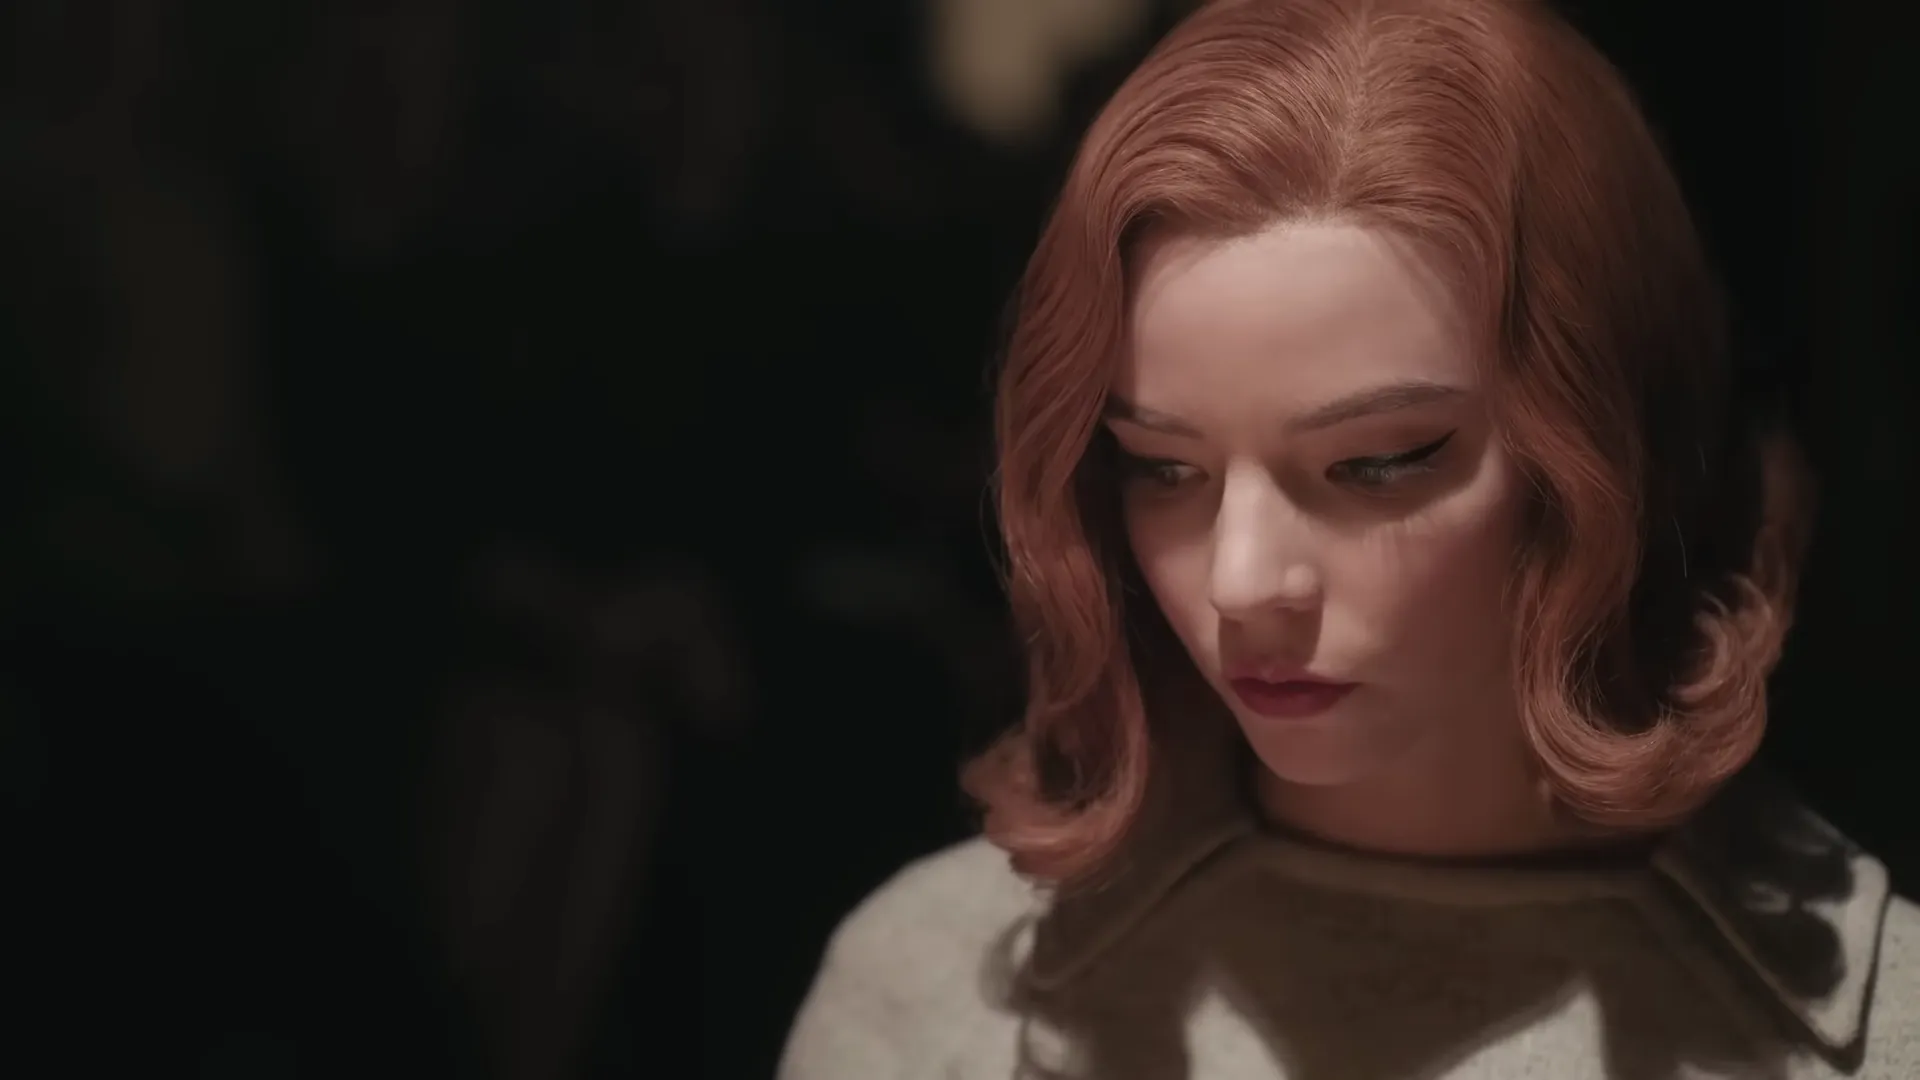
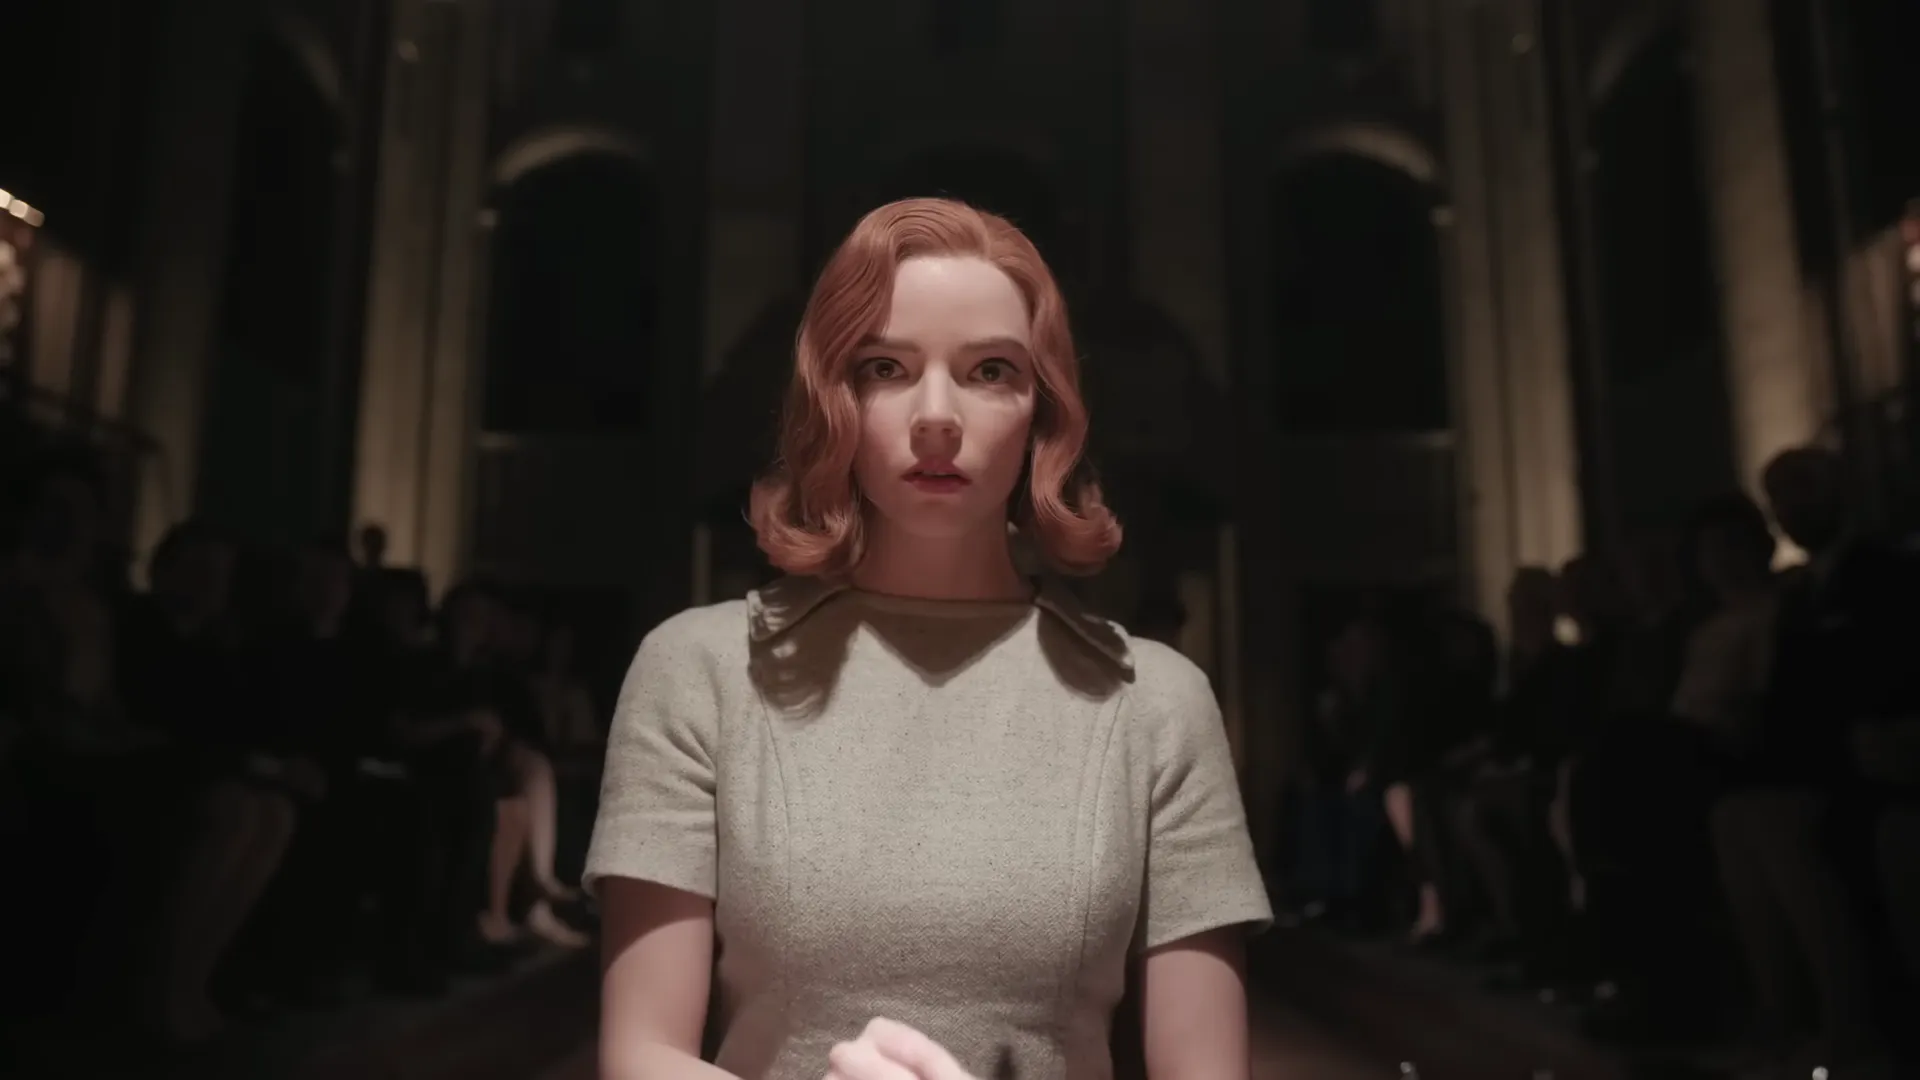
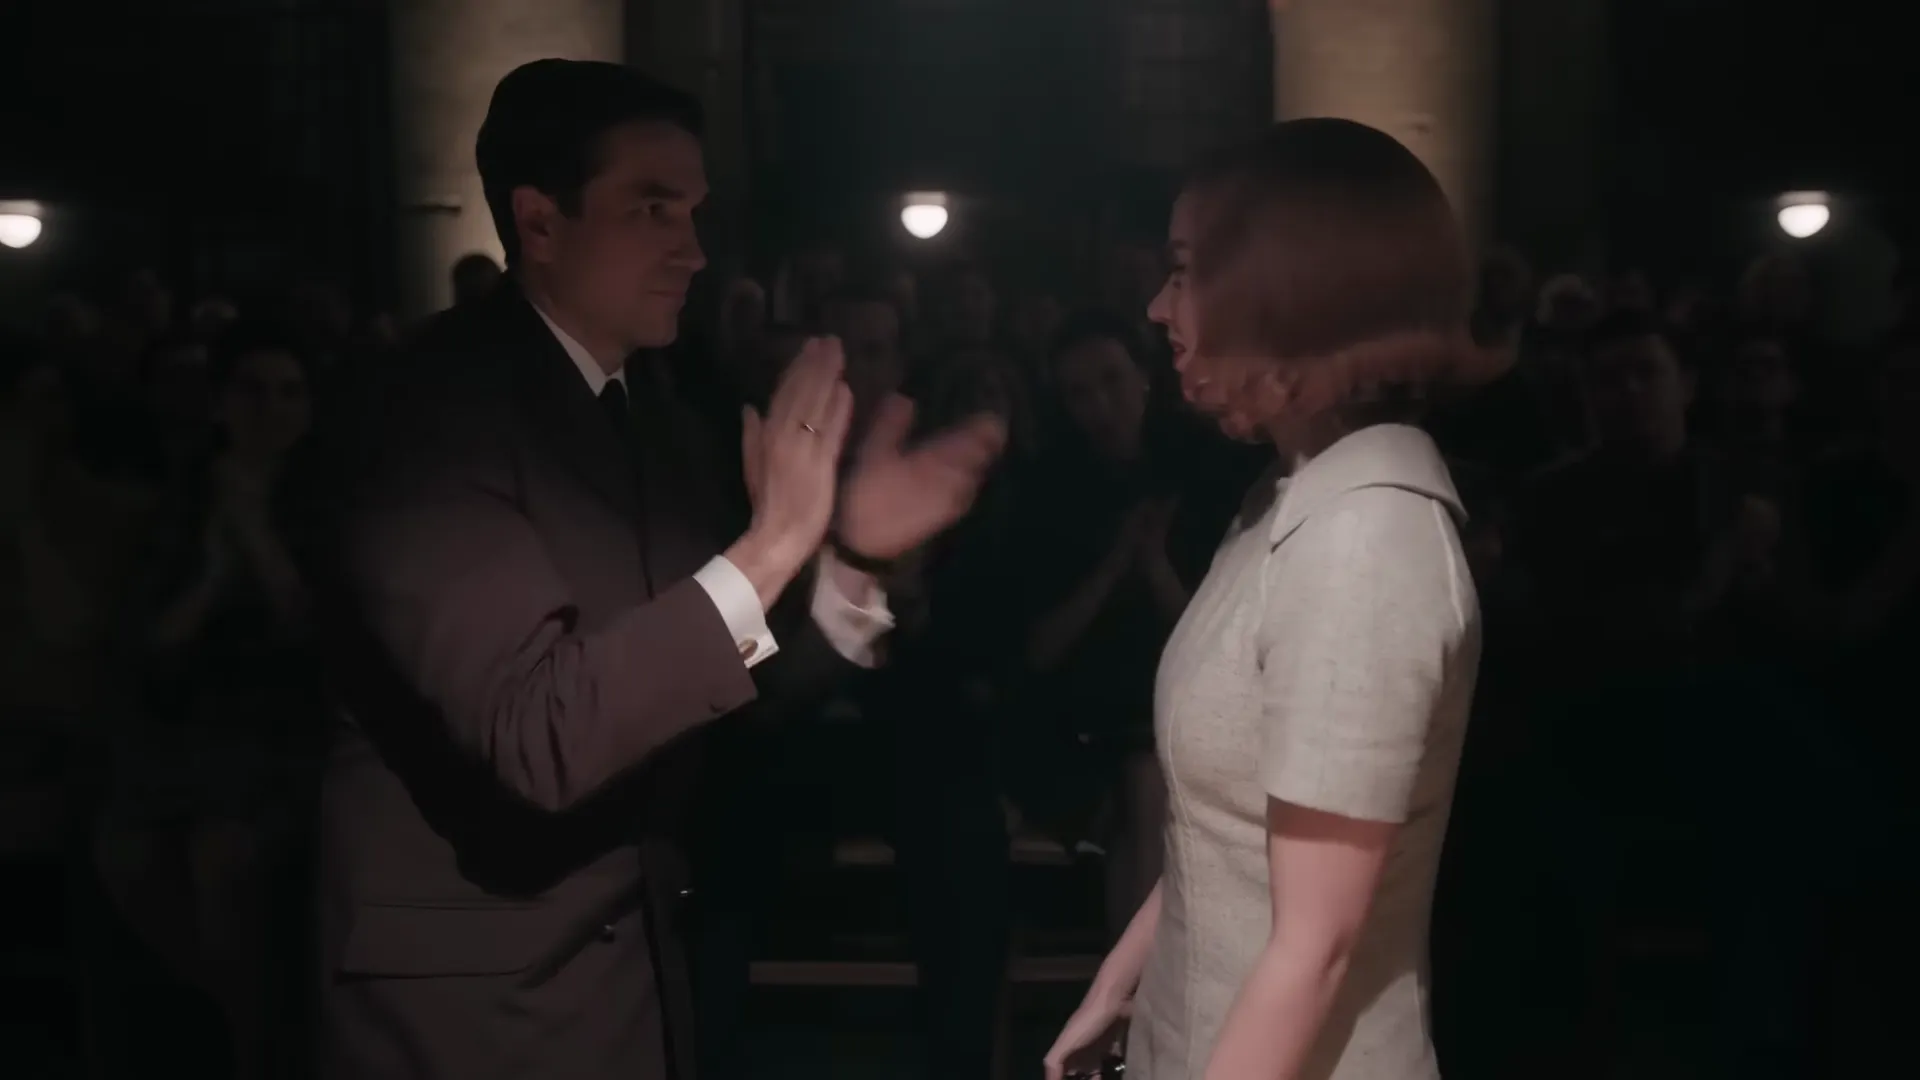

In [15]:
fv.select(fv.frame_idx, fv.pos_msec, fv.pos_frame, fv.frame).limit(3).collect()

## 05 - Retrieval: Visual Search

Now let's search videos visually. We want to find frames similar to any other frame or image.

We'll build a searchable [embedding index](https://docs.pixeltable.com/platform/embedding-indexes) on these frames using CLIP.

CLIP is a multimodal model from OpenAI that encodes images into embeddings that capture semantic meaning. This lets you find visually similar frames even if they don't look exactly alike - it understands what's in the image, not just pixel patterns.

Embedding models in Pixeltable are just another kind of user-defined function (UDF). They accept an image and return an array. Pixeltable supports a variety of HuggingFace embedding models as UDFs, but you can bring your own embedding model too.

More resources:
- In addition to CLIP, Pixeltable includes several built-in UDFs for Hugging Face models: link
- Learn more about [CLIP functions](https://docs.pixeltable.com/sdk/latest/huggingface#clip) and the [CLIP documentation](https://huggingface.co/docs/transformers/en/model_doc/clip).

To learn more about creating your own UDFs, see the [UDF decorator documentation](https://docs.pixeltable.com/sdk/latest/pixeltable#decorator-udf).

In [16]:
# Add CLIP embedding index on frames for similarity search
fv.add_embedding_index(
    fv.frame,
    embedding=pxtf.huggingface.clip.using(model_id='openai/clip-vit-base-patch32')
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


You can see the index now appears in our view schema:

In [ ]:
fv

Once you declare the index, you don't need to update it manually. From now on, the index will reflect the rows in the view and the index is maintained incrementally automatically by Pixeltable. This means if you add or remove rows from the base table, the index will always be up to date with the view.

Now let's perform visual search. First, we'll extract a query frame from the video to search for similar frames. The `[0, 0]` syntax returns the first row of the first column from the result set.


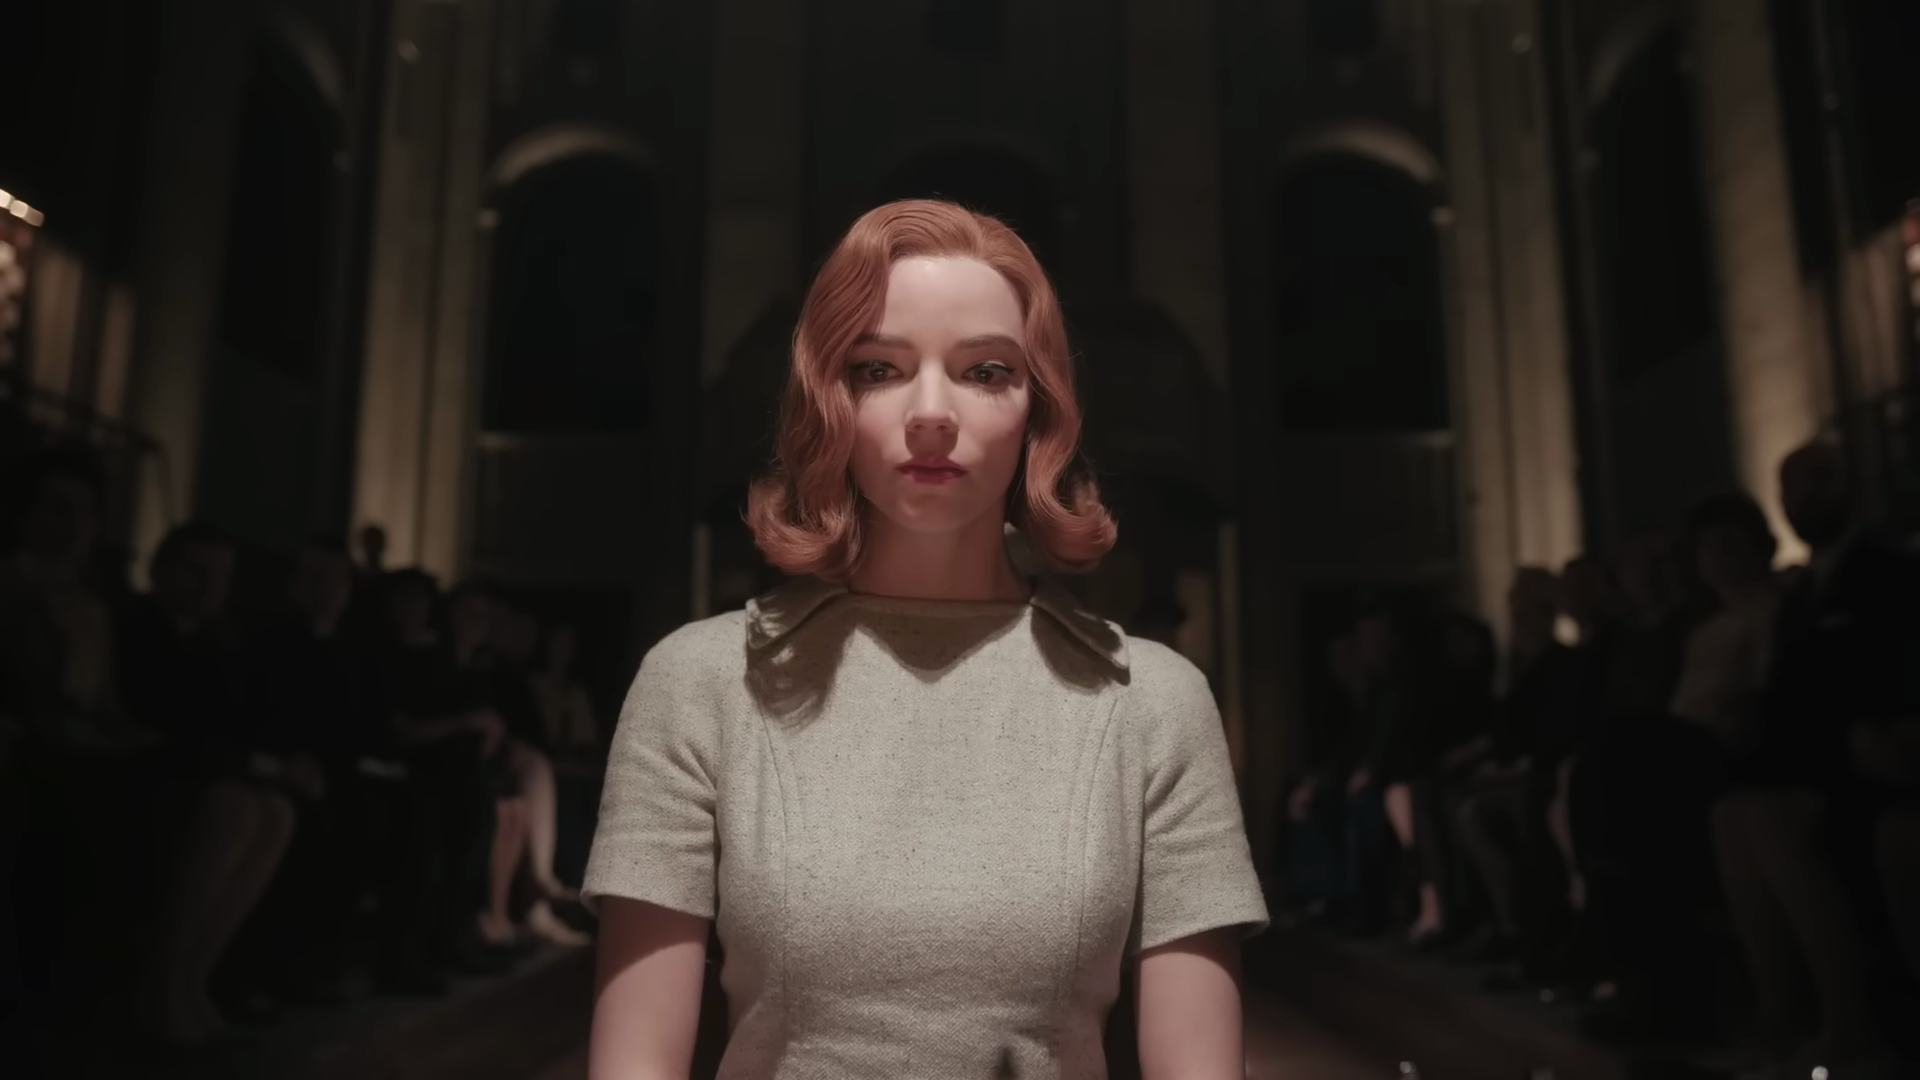

In [17]:
# Extract a query frame from the video at a timestamp
# Try 75, 200, and 360
query_frame = t.select(t.video.extract_frame(timestamp=75)).head()[0, 0]
query_frame

Now let's search for frames similar to our query frame.

We use the `similarity()` pseudo-function in Pixeltable, which is available on any column with an embedding index. You apply it directly to a column, and the parameter is the search item. Here we are searching with an image. The range of parameter types here is determined by the embedding function when you created the index. CLIP supports both text and image searches, so you could use either here.

If you have embedding functions that support a wider array of data types (like TwelveLabs, for example, which allows you to use audio or video for search), you can specify those.


pos_msec,frame,score
56598.208,,0.984
18852.167,,0.859
245078.167,,0.828
358191.167,,0.806

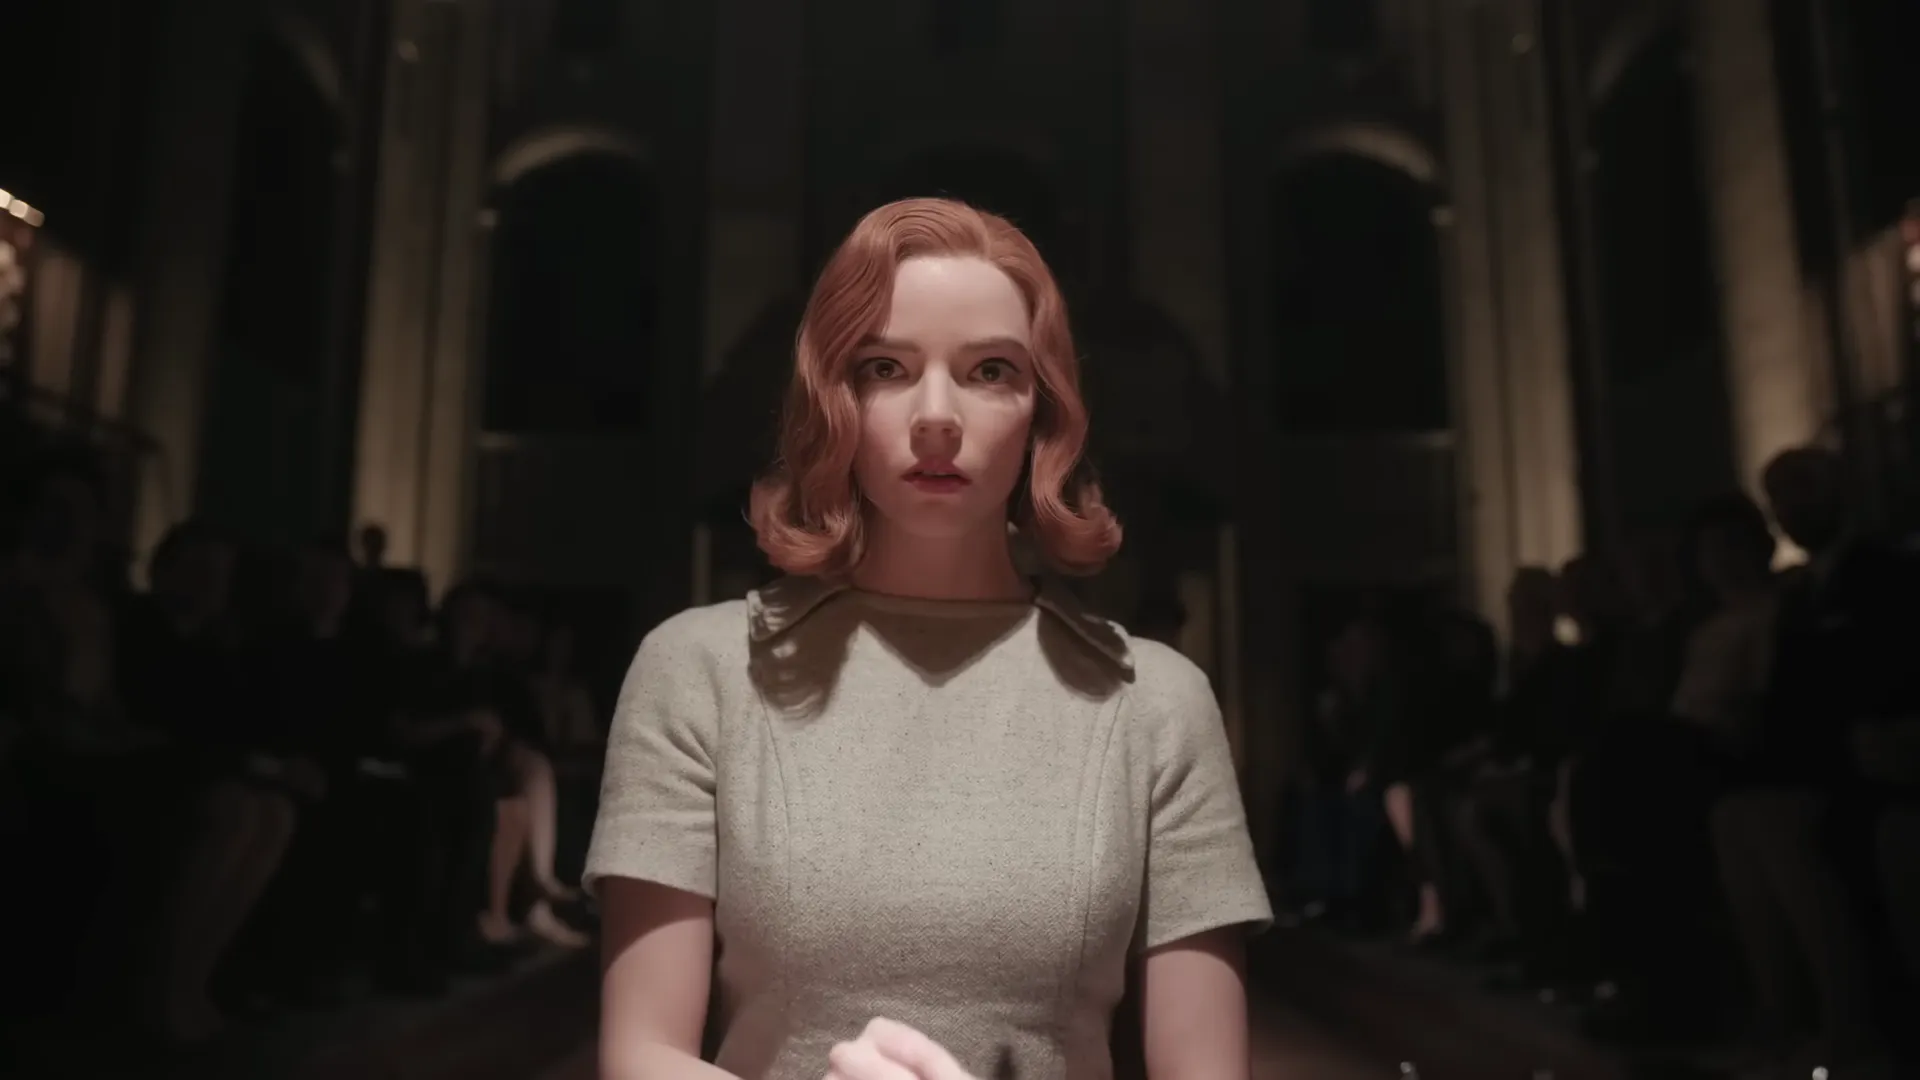
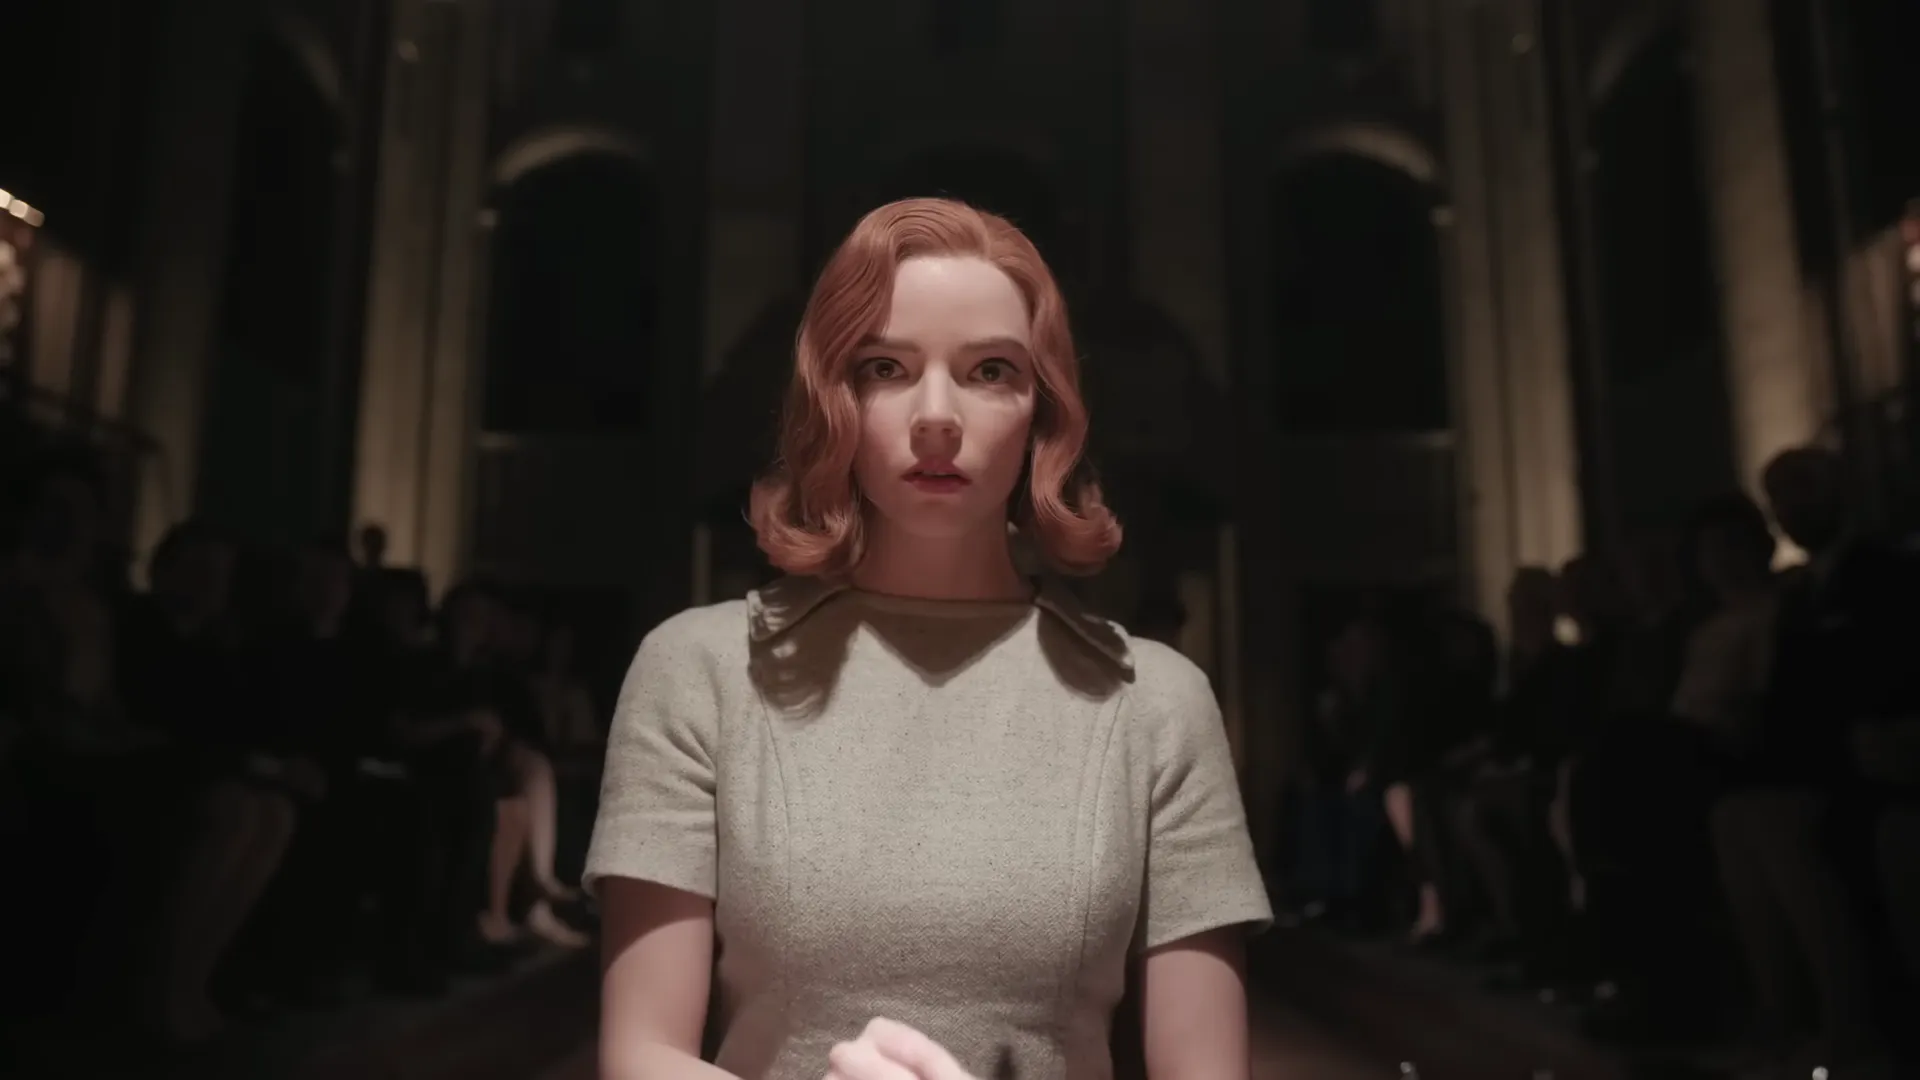
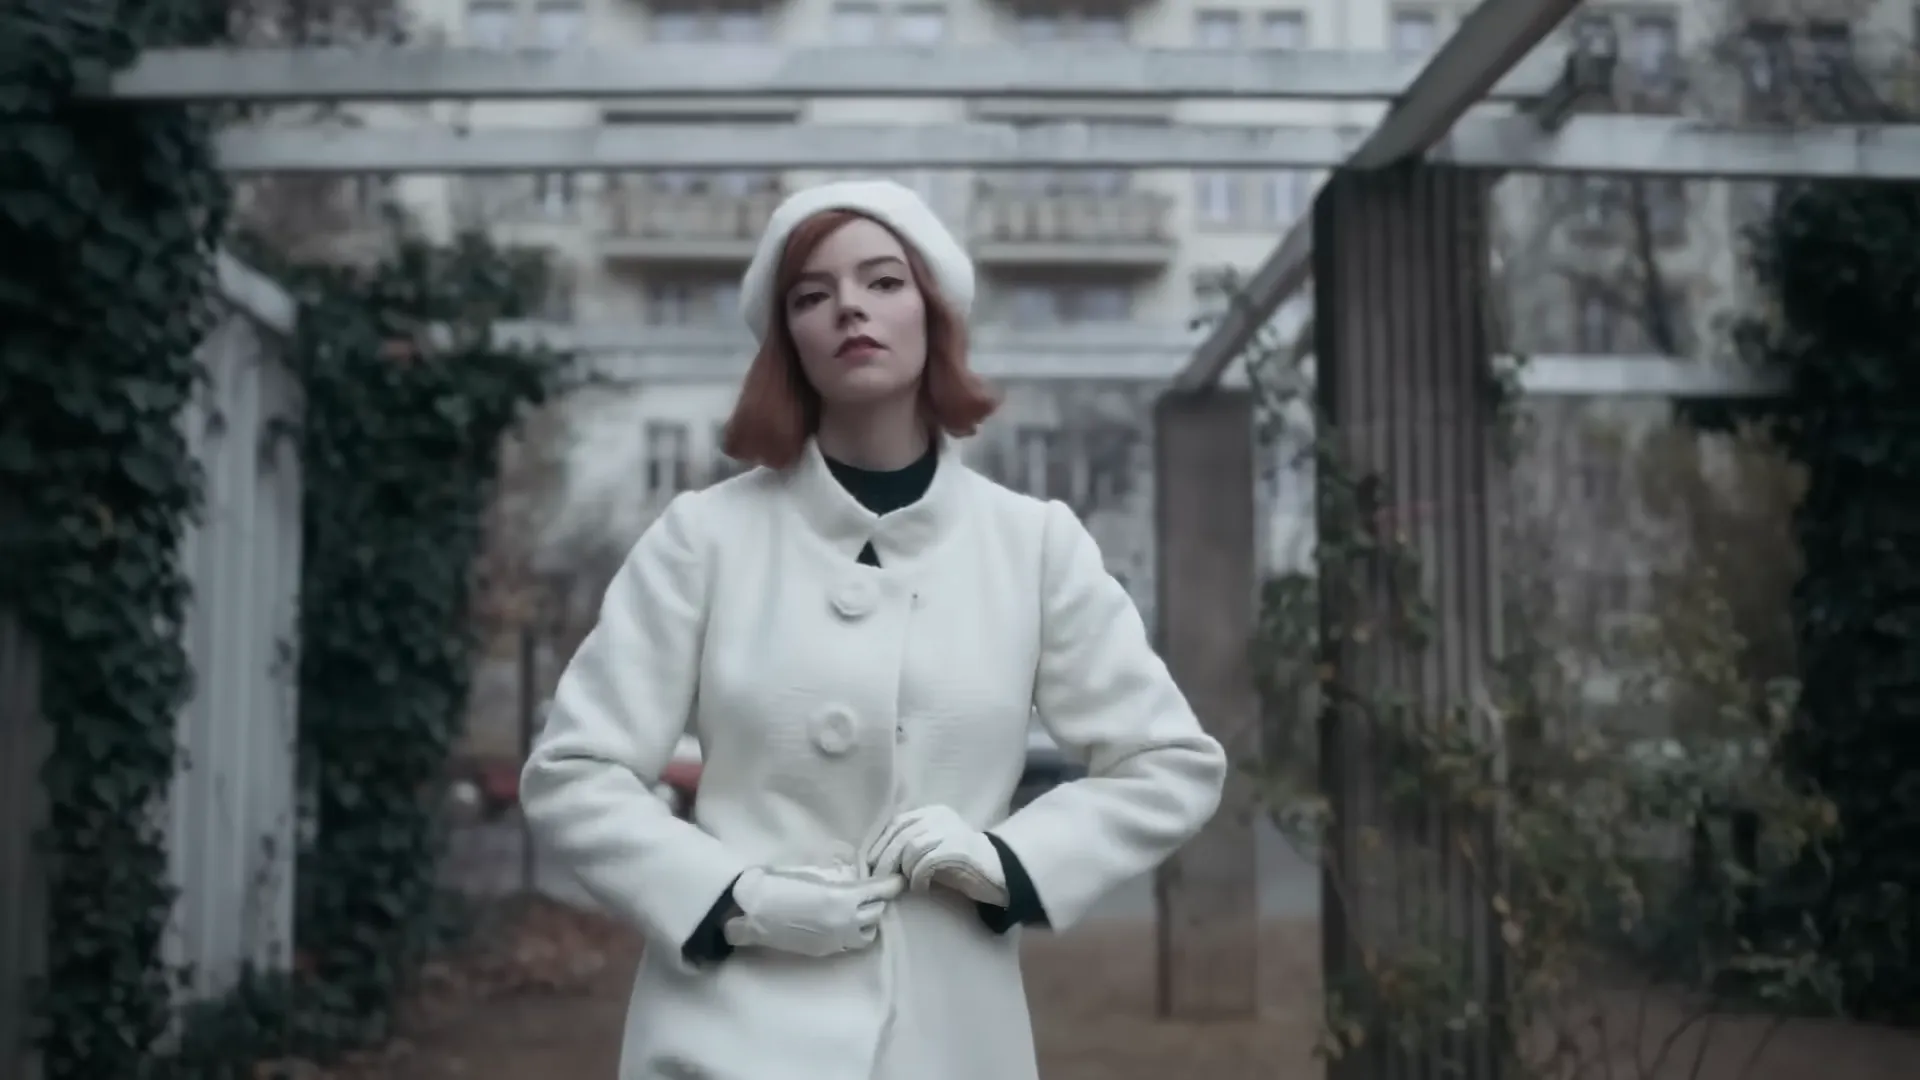
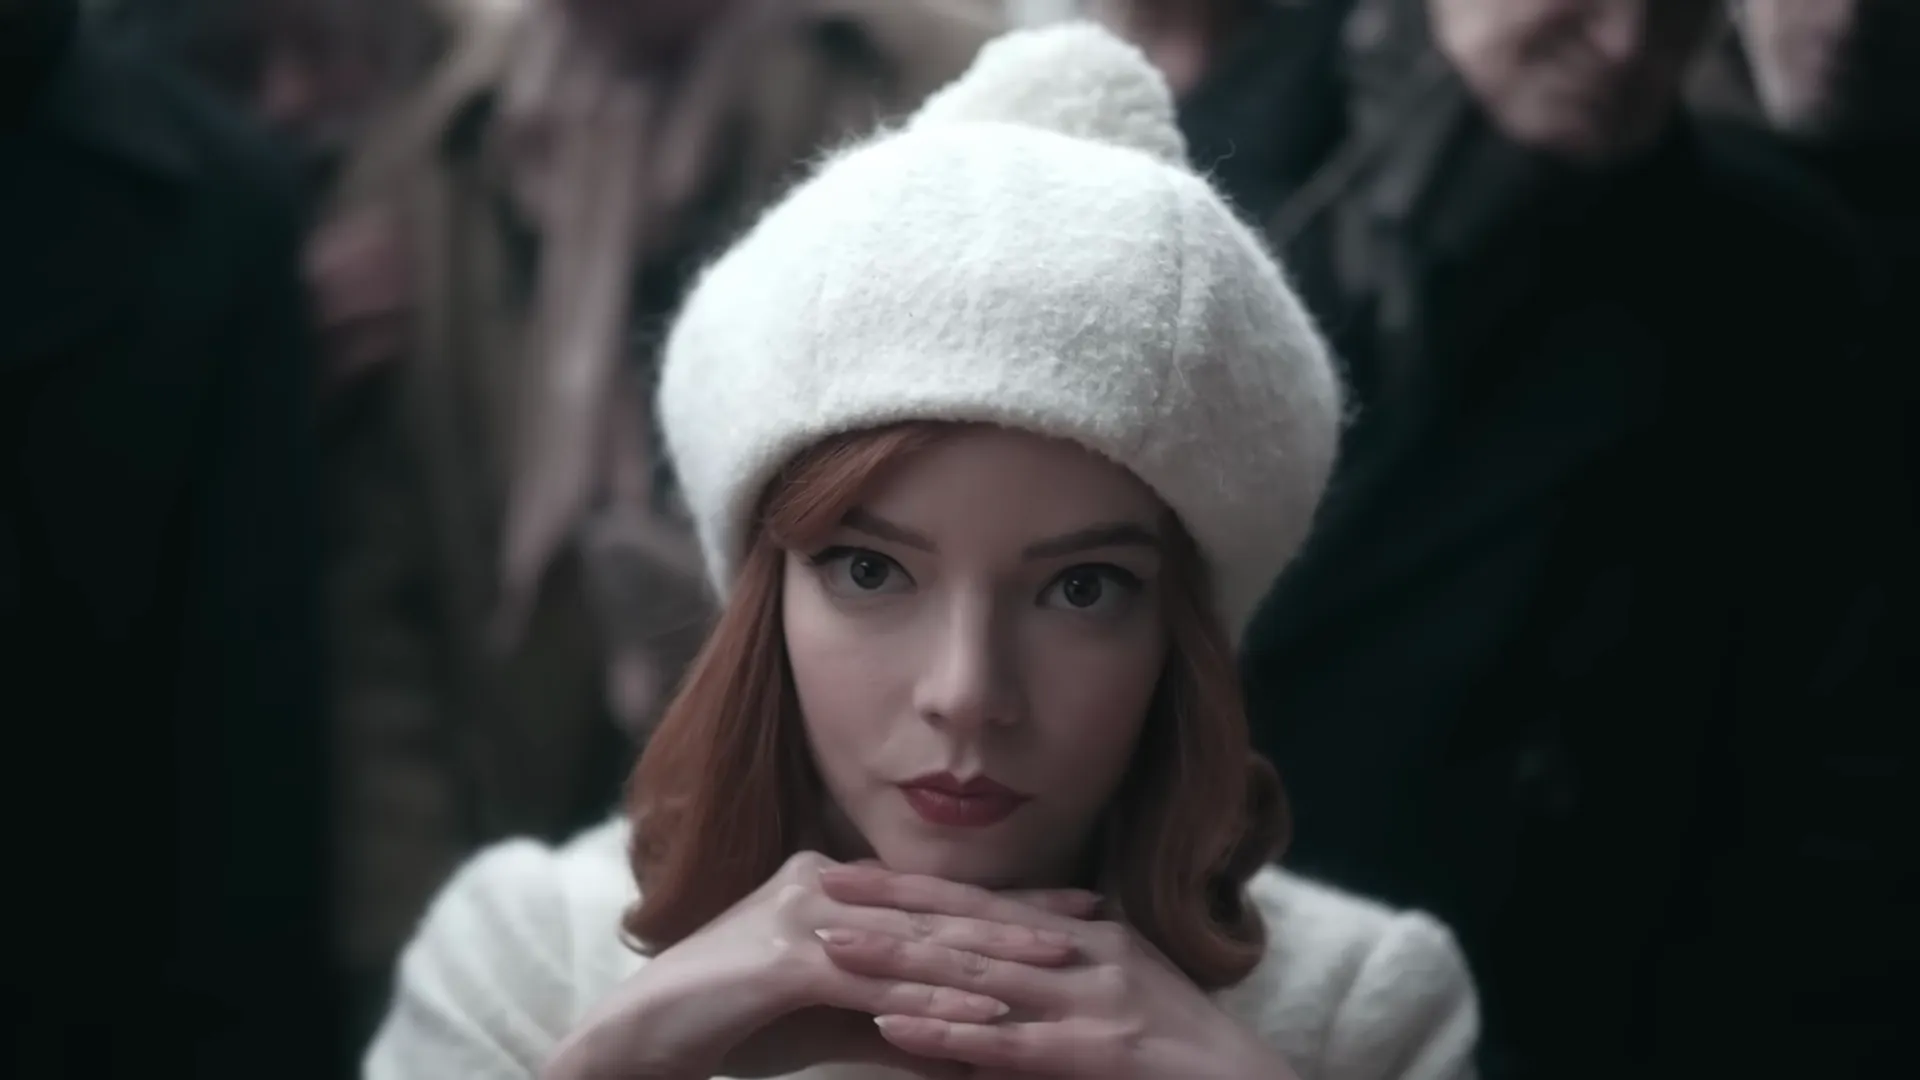

In [18]:
# Visual search - find frames similar to the query frame
sim = fv.frame.similarity(image=query_frame)

similar = (
    fv
    .order_by(sim, asc=False)
    .select(
        fv.pos_msec,
        fv.frame,
        score=sim
    )
    .limit(4)
    .collect()
)

similar  

## 06 - Retrieval: Cross-Modal Search

CLIP is a multimodal model - it can encode both images AND text into the same embedding space. This means you can search for frames using text queries, not just image queries.

Let's search for frames using text descriptions:

pos_msec,frame,score
169711.208,,0.284
320486.833,,0.23
358191.167,,0.226
56598.208,,0.207

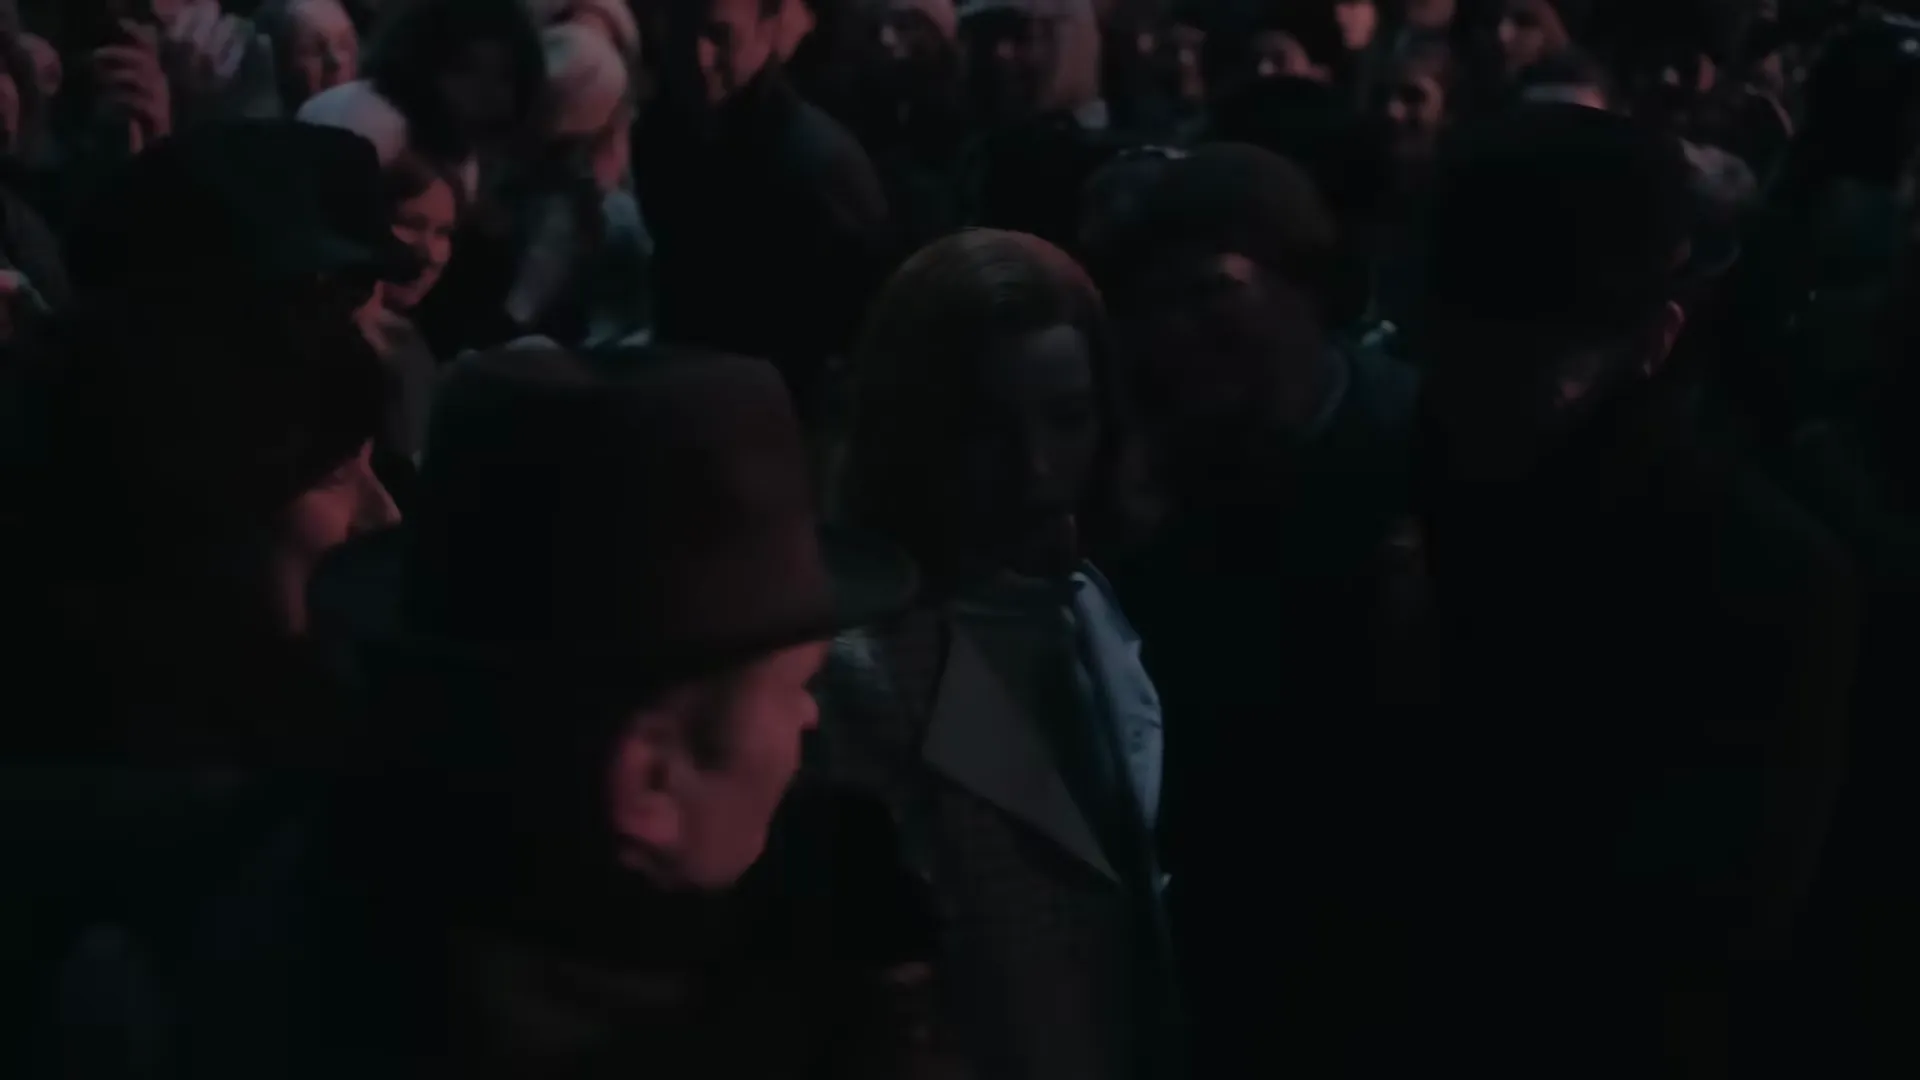
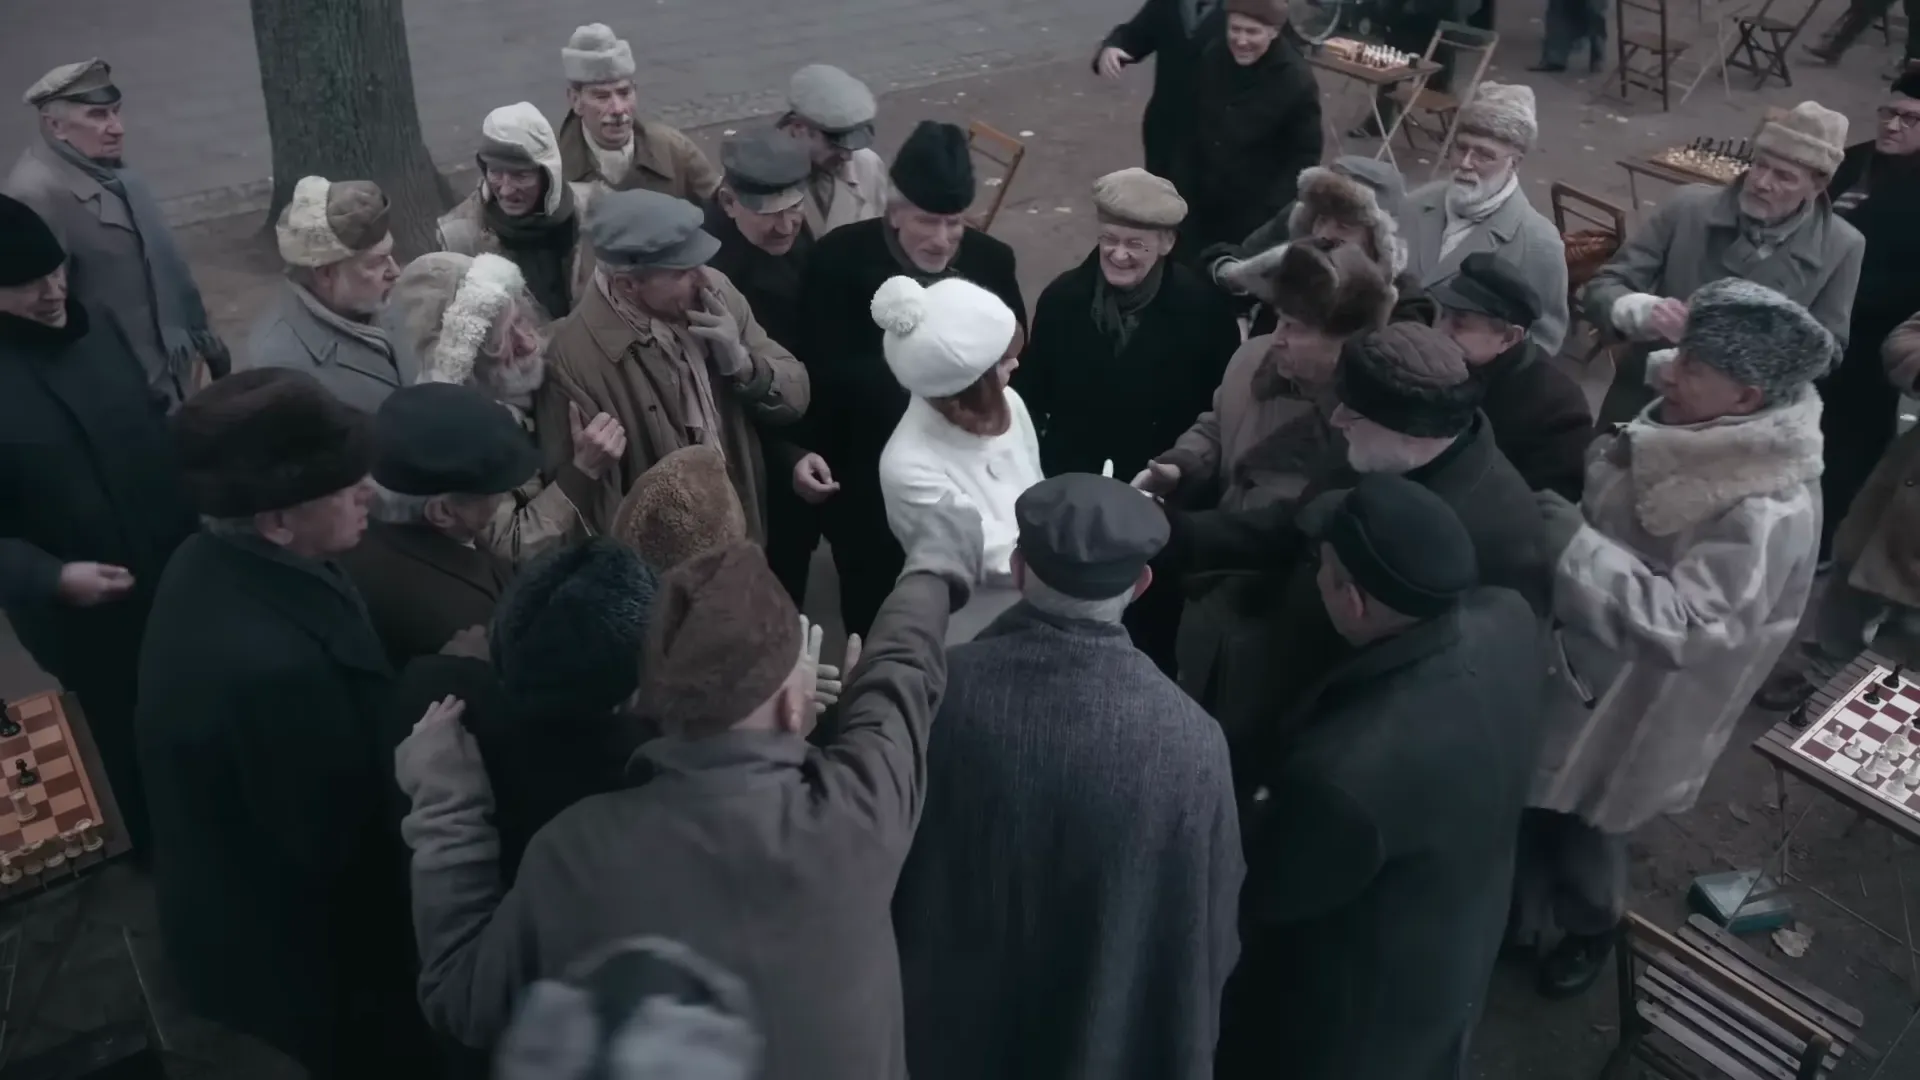
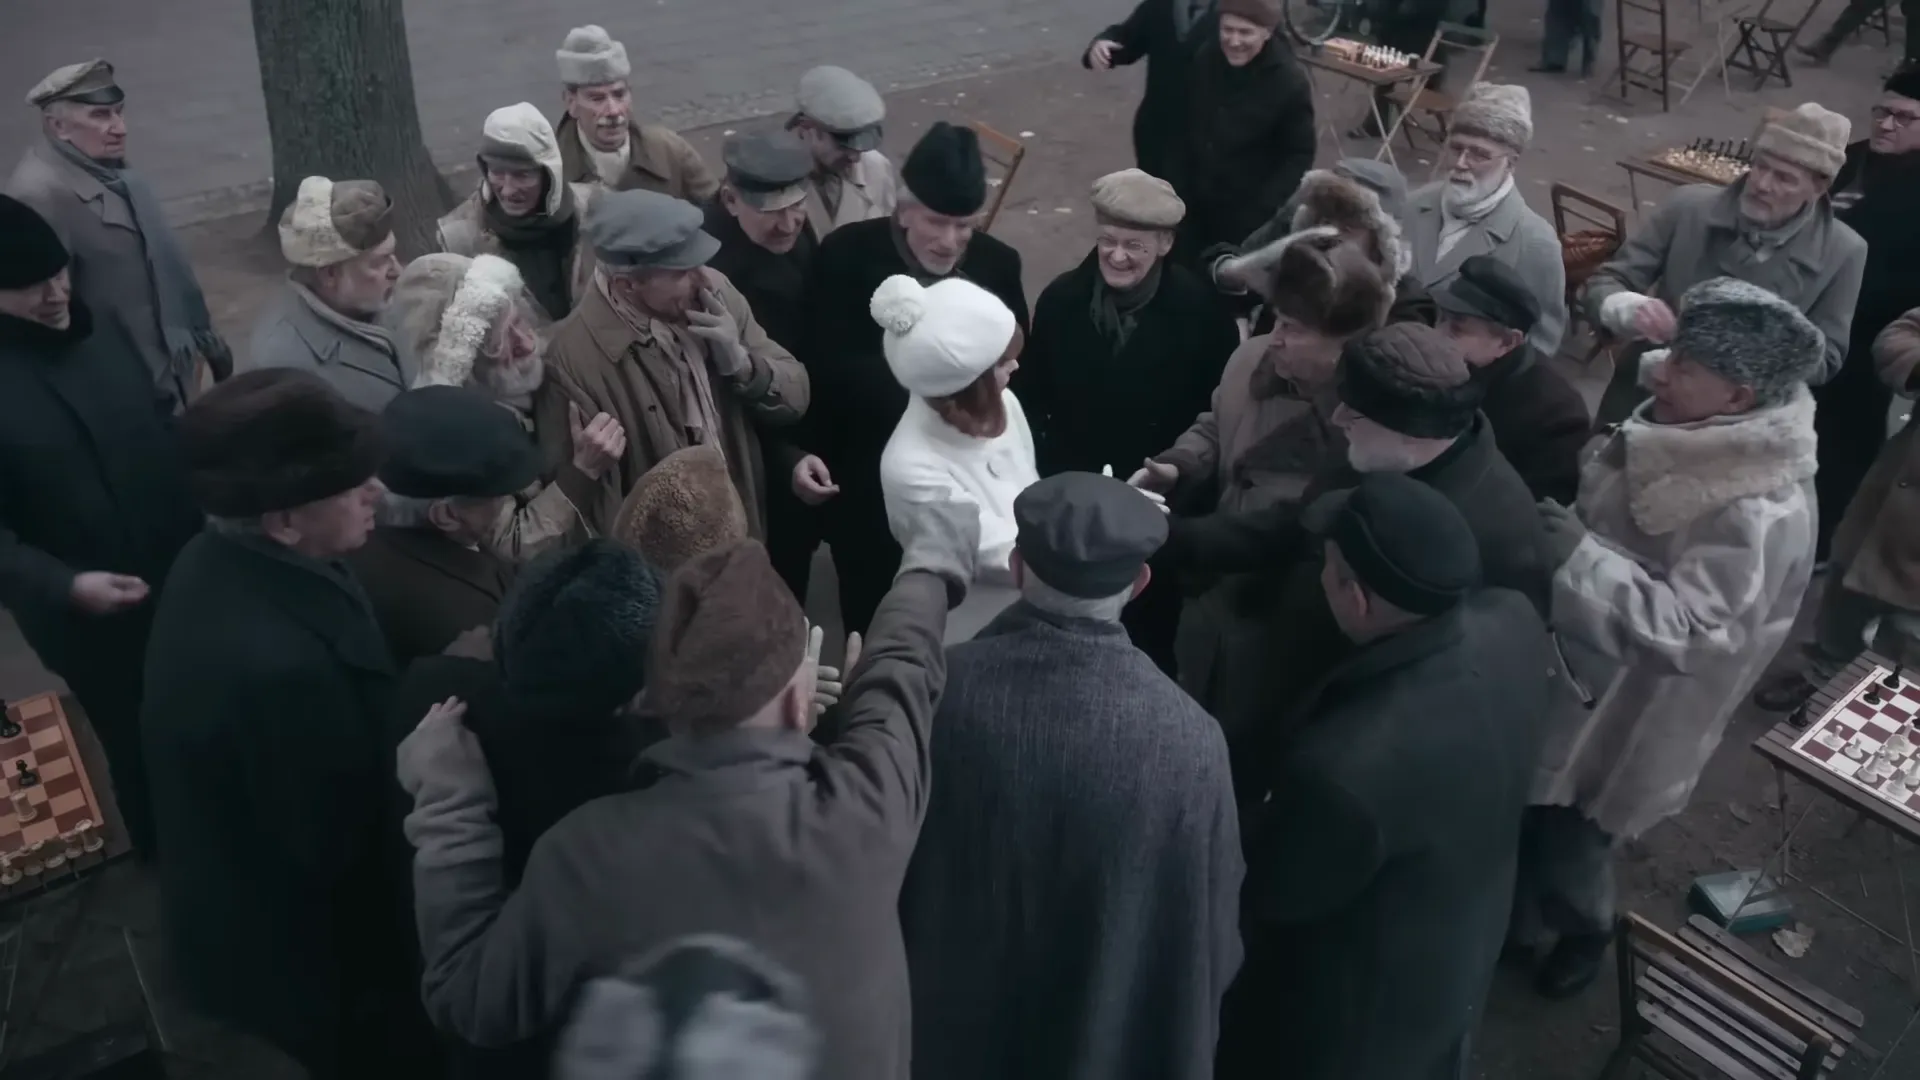
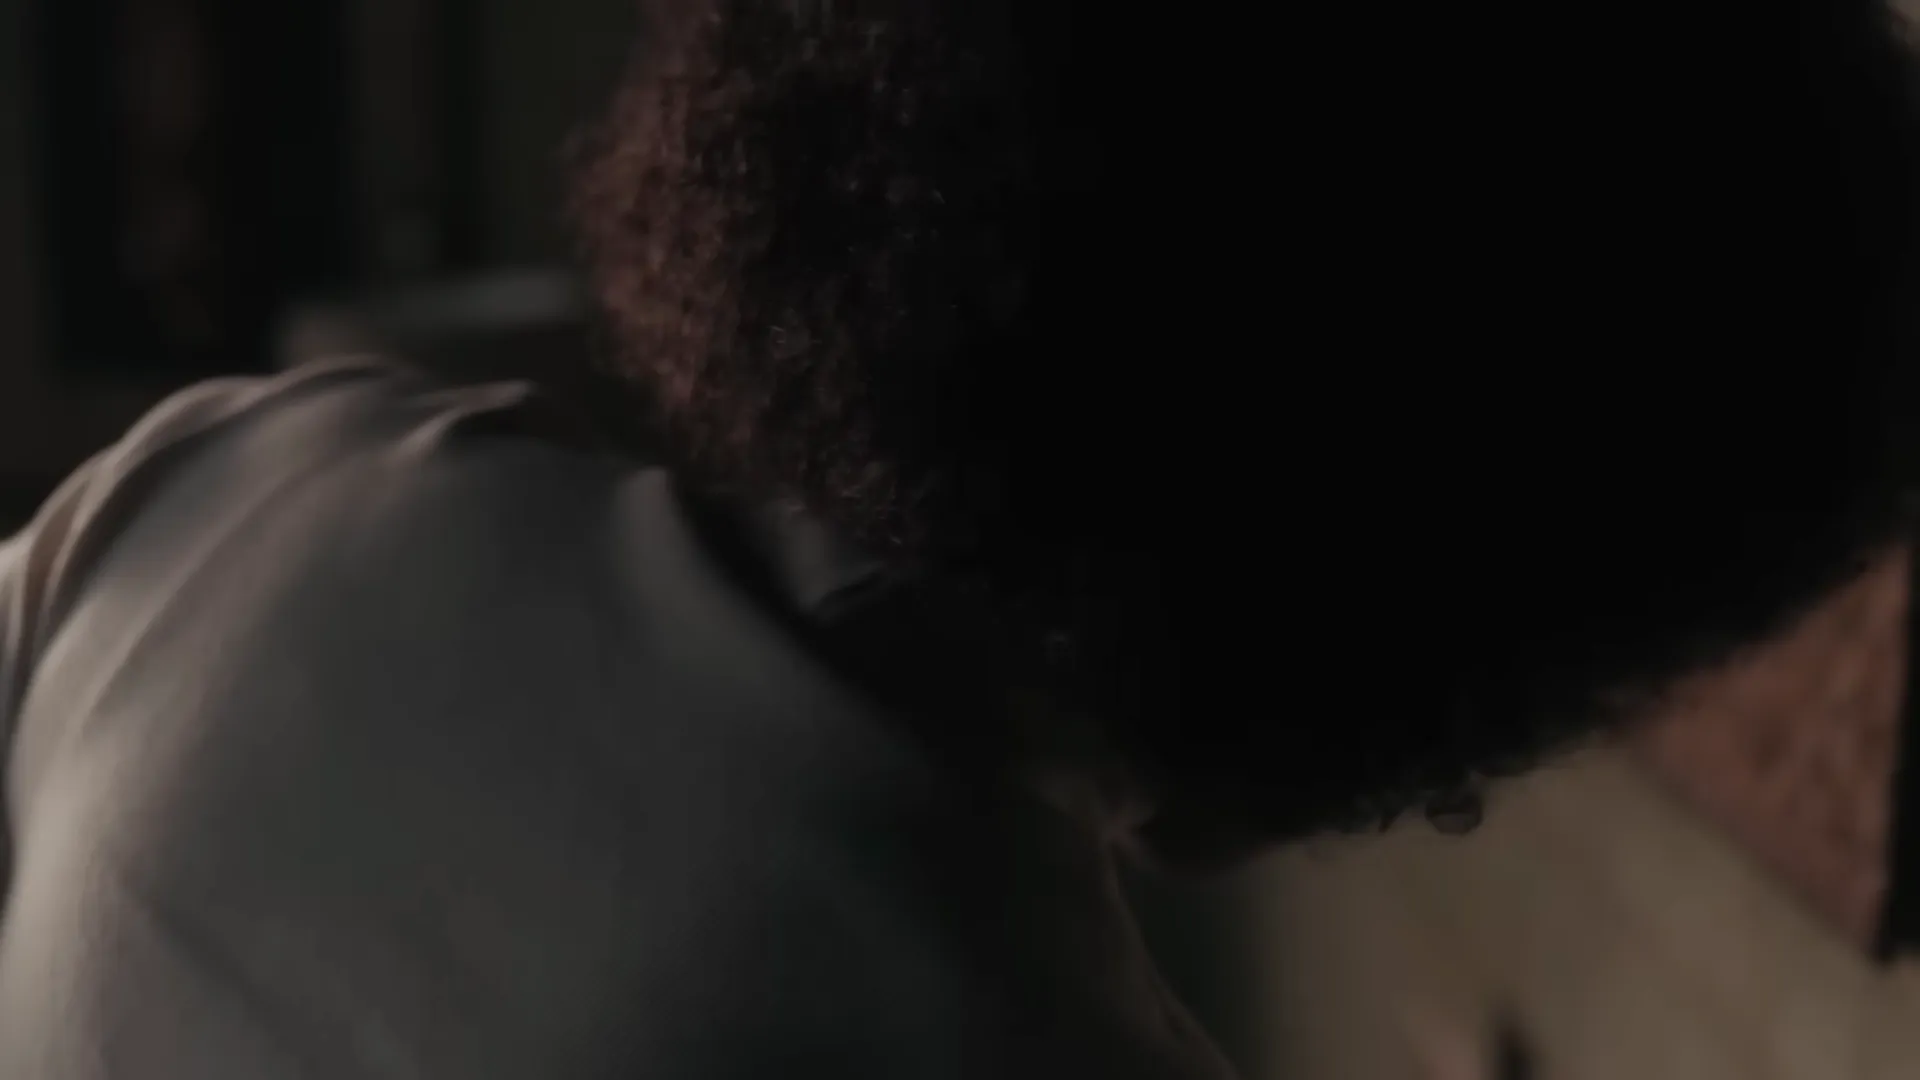

In [ ]:
# Text search - find frames using a text query
# The similarity() function works with text strings too - CLIP encodes them into the same embedding space
# Try different queries like: "crowd", "chess game", "winter day"
text_query = "crowd"

sim = fv.frame.similarity(string=text_query)

similar = (
    fv
    .order_by(sim, asc=False)
    .select(
        fv.pos_msec,
        fv.frame,
        score=sim
    )
    .limit(4)
    .collect()
)

similar  # See frames that match your text description

The CLIP UDF works with both image queries (like we did with `query_frame`) and text queries (like we just did with `"crowd"`). Images and text are encoded into the same semantic space, so you can search across modalities. Try different text queries to explore your video content.

## 07 - Persistent Storage Demo

Your data and computed columns survive kernel restarts. This is different from typical notebook workflows where you lose everything when the kernel dies.

Clear all your outputs, restart your kernel, then run the code below. Learn more about [persistence](https://docs.pixeltable.com/platform/persistence) and [database concepts](https://docs.pixeltable.com/platform/database).

In [20]:
%reset -f

In [21]:
import pixeltable as pxt
pxt.list_dirs()

['bug_test',
 'primetime-workshop',
 'notebook_index',
 'blob_storage_demo',
 'project',
 'bug_pos_test',
 'project/subdir']

In [22]:
pxt.list_tables('primetime-workshop')

['primetime-workshop/primetime_vids', 'primetime-workshop/video-frame-view']

Any of these tables are retrievable because Pixeltable persistently stores all of our data and computed columns. Let's get the table we created using [`get_table()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-get-table):

In [23]:
t = pxt.get_table('primetime-workshop/primetime_vids')

Check the table - notice the computed `duration` column is still there:

In [24]:
t

table 'primetime-workshop/primetime_vids'

 Column Name    Type        Computed With
       video   Video                     
       title  String                     
   promo_img   Image                     
  promo_text  String                     
    duration   Float  get_duration(video)

Run a query and collect to see the contents. All your computed columns are still there - no need to recompute expensive operations after a kernel restart.

video,title,promo_img,promo_text,duration
,The Queens Gambit,,"Set during the Cold War era, orphaned chess prodigy Beth Harmon struggles with addiction in a quest to become the greatest chess player in the world.",377.043

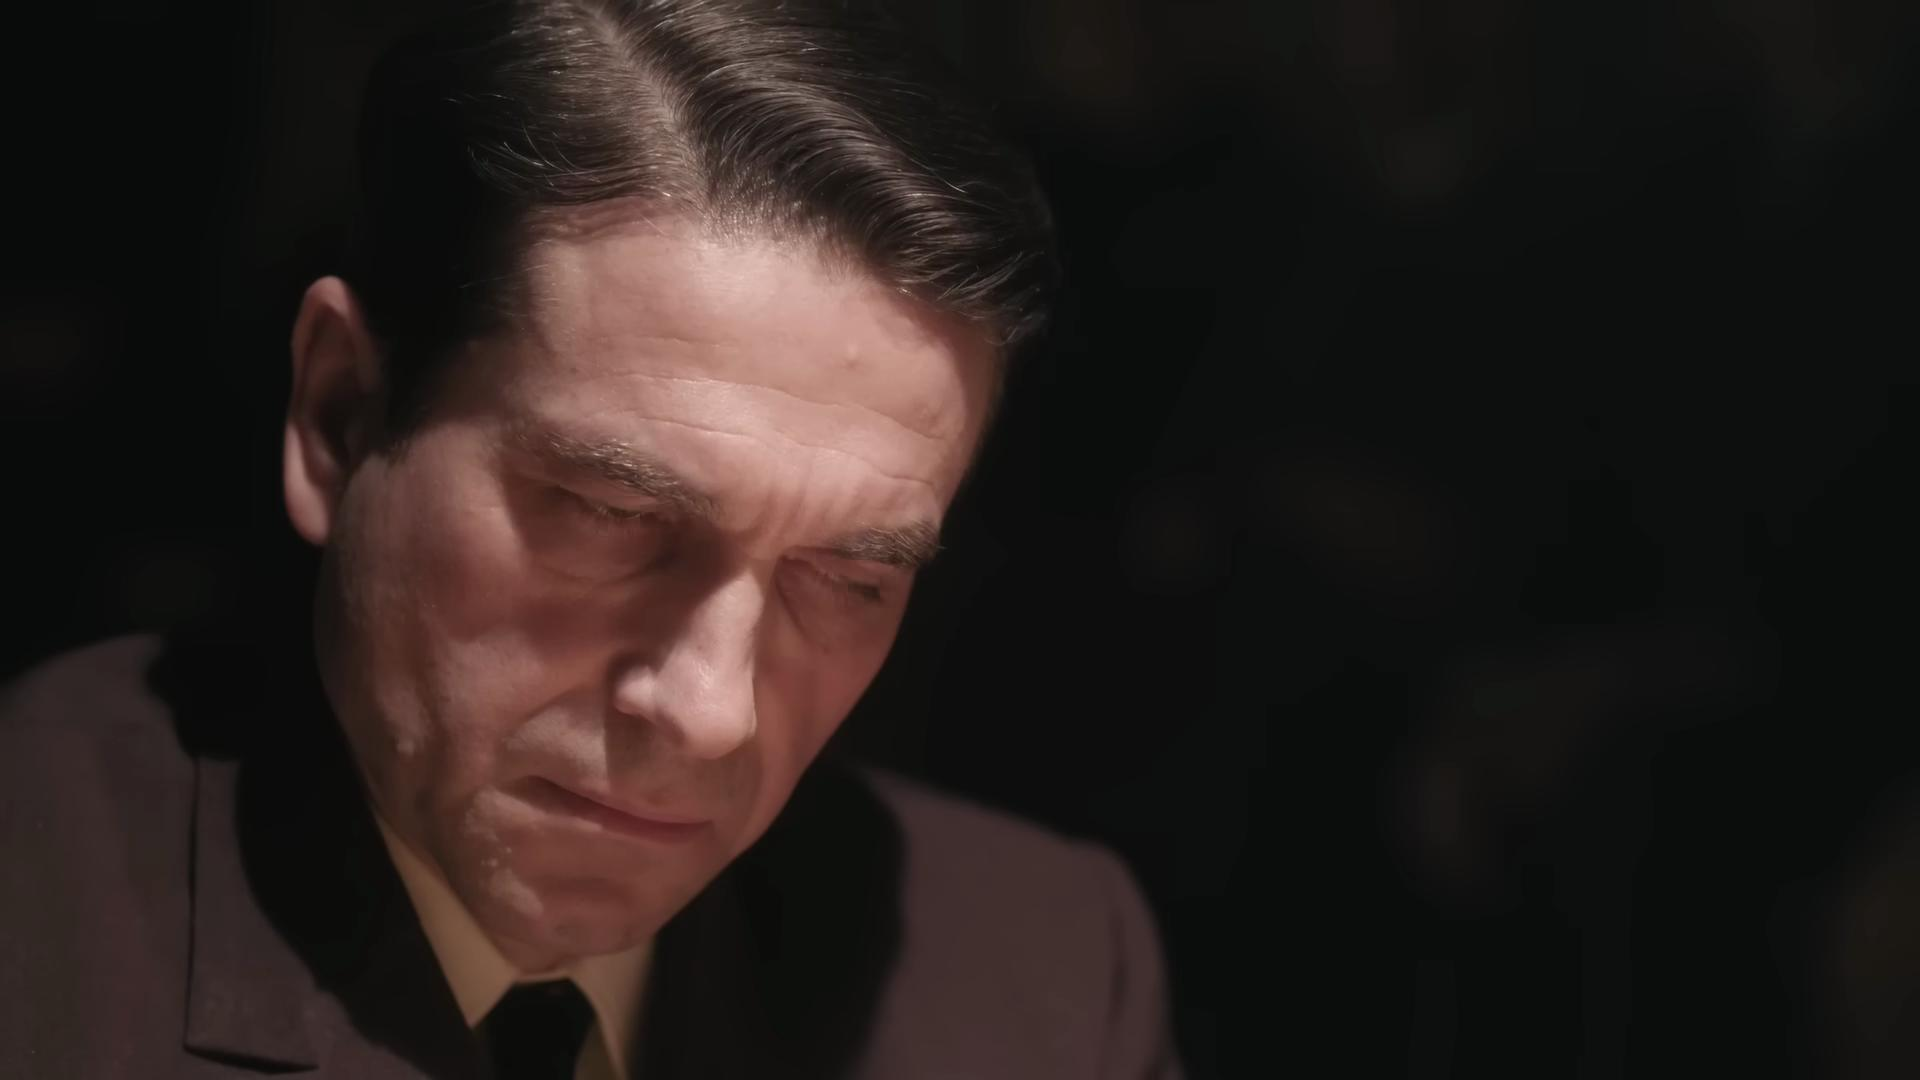
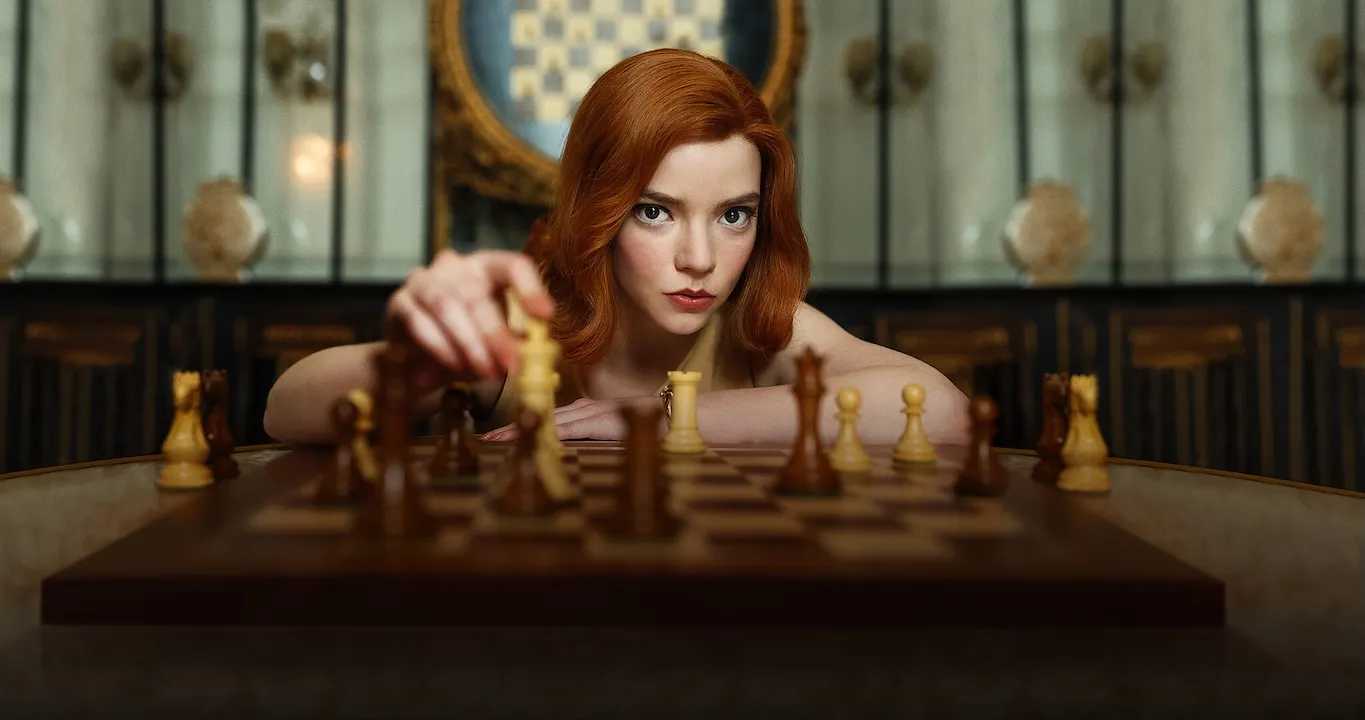

In [25]:
t.collect()

## Wrap-Up

You built a complete visual search pipeline using Pixeltable:

```
┌─────────────────────────────────────────────────────────────────────────────┐
│  INPUT            EMBED              SEARCH                   RESULTS       │
│                                                                             │
│  ┌────────┐      ┌────────┐        ┌──────────────┐         ┌────────────┐  │
│  │ Video  │─────▶│ CLIP   │───────▶│  Similarity  │────────▶│  Matching  │  │
│  │ Frames │      │Vectors │        │    Search    │         │   Frames   │  │
│  └────────┘      └────────┘        └──────────────┘         └────────────┘  │
│      │               │                     │                       │        │
│      │               │                     │                       │        │
│  Extract         Generate            Query with              Ranked by      │
│  frames          embeddings          reference               similarity     │
│  from video      using CLIP          image/text              score          │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

**Each step is declarative:**
- **Input**: Video data with all columns persists in the database
- **Embed**: CLIP generates vector embeddings for each frame automatically
- **Search**: Similarity queries work with both images (Visual Search) and text (Cross-Modal Search)
- **Results**: Frames ranked by similarity score

**Next up:** In Act 2, you'll add a second search modality—semantic search over audio transcripts.

---

## Learn More

### Storage & Tables
- [Tables and Data Operations](https://docs.pixeltable.com/tutorials/tables-and-data-operations) - Creating tables and inserting data
- [Type System](https://docs.pixeltable.com/platform/type-system) - Media types including Video, Image, and Audio
- [Configuration](https://docs.pixeltable.com/platform/configuration) - Configuring Pixeltable settings

**How Media is Stored:**
- PostgreSQL stores only file paths/URLs, never raw media data.
- Inserted local files: path stored, original file remains in place.
- Inserted URLs: URL stored, file downloaded to File Cache on first access.
- Generated media (computed columns): saved to Media Store (default: local, configurable to S3/GCS/Azure per-column).
- File Cache size: configure via `file_cache_size_g` in `~/.pixeltable/config.toml`. See [configuration guide](https://docs.pixeltable.com/platform/configuration).

### Computed Columns
- [Computed Columns Tutorial](https://docs.pixeltable.com/tutorials/computed-columns) - Understanding computed columns
- [Video Functions](https://docs.pixeltable.com/sdk/latest/video) - Video operations like `get_duration()` and `extract_frame()`

### Queries & Views
- [Queries and Expressions](https://docs.pixeltable.com/tutorials/queries-and-expressions) - Querying your data
- [Views Platform Guide](https://docs.pixeltable.com/platform/views) - Creating and using views
- [frame_iterator()](https://docs.pixeltable.com/sdk/latest/video#iterator-frame-iterator) - Extracting frames from video

### Search & Embeddings
- [Embedding Indexes](https://docs.pixeltable.com/platform/embedding-indexes) - Building searchable indexes
- [Similarity Search Cookbooks](https://docs.pixeltable.com/howto/cookbooks/search/search-similar-images) - Performing similarity search
- [CLIP Functions](https://docs.pixeltable.com/sdk/latest/huggingface#udf-clip) - Using CLIP for image embeddings
- [HuggingFace Integration](https://docs.pixeltable.com/sdk/latest/huggingface) - Working with HuggingFace models

## Functions Used

This notebook uses the following Pixeltable functions:

- [`add_computed_column()`](https://docs.pixeltable.com/sdk/latest/pixeltable#add-computed-column) - Add computed columns to tables
- [`add_embedding_index()`](https://docs.pixeltable.com/sdk/latest/pixeltable#add-embedding-index) - Create embedding indexes for similarity search
- [`create_table()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-create-table) - Create new tables
- [`create_view()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-create-view) - Create views from tables
- [`extract_frame()`](https://docs.pixeltable.com/sdk/latest/video#udf-extract_frame) - Extract frames from video at specific timestamps
- [`frame_iterator()`](https://docs.pixeltable.com/sdk/latest/video#iterator-frame-iterator) - Iterator to extract multiple frames from video
- [`get_duration()`](https://docs.pixeltable.com/sdk/latest/video#udf-get_duration) - Get video duration
- [`get_table()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-get-table) - Retrieve existing tables
- [`list_tables()`](https://docs.pixeltable.com/sdk/latest/pixeltable#func-list-tables) - List all tables in the database
- [`similarity()`](https://docs.pixeltable.com/sdk/latest/pixeltable#similarity) - Perform similarity search using embedding indexes